# Self Organizing Maps

# Sommaire


* ##   [Import](#S1)

* ##   [Definitions](#S2)
> ### [Training](#S2_1)
> ### [Subplots](#S2_2)
> ### [Heatmap](#S2_3)
> ### [Interactive SOM](#S2_4)


* ##   [Colors](#S3)
> ### [First visualization](#S3_1)
> ### [Errors](#S3_4)
> ### [Interactive SOMs](#S3_2)
> ### [Heatmaps](#S3_3)
> ### [Tests normalizations](#S3_5)
> ### [GHSOM](#S3_6)
> ### [Tests hyperparams auto](#S3_7)


* ##   [Galaxy catalogs](#S4)
> ### [Loading datasets](#S4_1)
> ### [Definition : cuts and normalizations](#S4_2)
> ### [Selecting variables](#S4_3)
> ### [Training and visualizations](#S4_4)

<a name="S1"></a>
# Import

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from ipywidgets import (interactive, 
                        IntSlider, FloatSlider,
                        Checkbox,
                        fixed, Label, Layout
                        )

In [ ]:
!pip install minisom

In [8]:
from minisom import MiniSom

[minisom](https://github.com/JustGlowing/minisom/tree/35e32cf4adeceb807d699c27c044c709c7ca4e3c) on github

\

---

\

Loading Drive and packages :

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
cd drive/My\ Drive/Colab\ Notebooks

<a name="S2"></a>
# Main definitions

<a name="S2_1"></a>
## Training

In [254]:
def train_som(data, sigma, learning_rate, iterations, 
              verbose=False, topology='rectangular', size='default'):
    """
    Params:
    - data : array, training dataset
    - sigma : float, spread of the neighborhood function, needs to be adequate to the dimensions of the map.
    - learning rate : float, determines the step size at each iteration
    - iterations : int, determine the time of the training

    Optional params:
    - verbose : bool, informations along the training
    - topology : str, topology of the map, -rectangular- or -hexagonal-
    - size : tuple, size of the map

    Return :
    - som : MiniSom, trained SOM
    - weights : array, weights of the map
    """

    rows, cols = data.shape

    if size=='default':
        som_x = int(np.sqrt(5*np.sqrt(rows)))
        som_y = som_x
    else:
        try:
            som_x, som_y = size
        except:
            raise ValueError("wrong input for -size-")

    som = MiniSom(som_x, som_y,
                  input_len = cols,
                  sigma = sigma,
                  learning_rate = learning_rate,
                  topology = topology)
    
    som.random_weights_init(data)

    som.train_random(data, iterations, verbose=verbose)

    weights = som.get_weights()

    return som, weights

### Manual training

with modified Minisom

In [13]:
cd minisom_perso

/content/drive/My Drive/Colab Notebooks/minisom_perso


In [14]:
from minisom_perso import MiniSom_perso

In [15]:
cd ..

/content/drive/My Drive/Colab Notebooks


In [257]:
def train_and_get_error(X_train, X_test, sigma, learning_rate, iterations, frequence, 
                        topological_error=False, animated=True, sig_view=True):
    """
    Training with a modified MiniSom to get the sigma and learning rate through the process

    Params:
    - X_train, X_test : arrays, training and test datasets
    - sigma : float, spread of the neighborhood function, needs to be adequate to the dimensions of the map.
    - learning rate : float, determines the step size at each iteration
    - iterations : int, determine the time of the training
    - frequence : int, learning interval for errors

    Optional params:
    - topological_error : bool, whether the topological error is to be learned or not
    - animated : bool, show the SOM on live during the training
    - sig_view : bool, show the sigma on live during the training

    Return :
    - som : Minisom, trained SOM
    - weights : array, weigths of the SOM
    - iter_x : array, iterations
    - q_error : array, quantization error for the training dataset
    - q_error_val : array, quantization error for the validation dataset
    - t_error : array, topological error
    - mapmean : array, distance map mean
    - sig : array, sigma
    - learnR : array, learning rate
    """

    rows, cols = X_train.shape
    som_x = int(np.sqrt(5*np.sqrt(rows)))
    som_y = som_x


    som = MiniSom_perso(som_x, som_y, cols, sigma, learning_rate)

    som.random_weights_init(X_train) 

    q_error = [] ; t_error = []
    q_error_val = []
    iter_x = []
    mapmean = []
    sig = np.zeros(iterations)
    learnR = np.zeros(iterations)

    if animated:
        from IPython.display import clear_output

    for i in range(iterations):
        rand_i = np.random.randint(len(X_train)) # This corresponds to train_random() method.

        ####
        # modification here, original -som.update()- doesn't return anything
        sig[i], learnR[i] = som.update_perso(X_train[rand_i], som.winner(X_train[rand_i]), i, iterations)
        ####

        if (i+1) % frequence == 0:
            q_error.append(som.quantization_error(X_train)) # loss
            q_error_val.append(som.quantization_error(X_test)) # val_loss
            if topological_error:
                t_error.append(som.topographic_error(X_train)) # topo. error
            iter_x.append(i) # iter 
            mapmean.append(np.mean(som.distance_map())) # distance map mean

            if not animated:
                print('\r [ %d / %d ] ; %d %%'%(i+1, iterations, 100*(i+1)/iterations), end='')

            if animated: # show weights and distance map during the training
                fig, ax = plt.subplots(1, 2, figsize=(14,7))
                
                ax[0].imshow(som.get_weights())
                ax[0].set_title('sigma %.2f' % sig[i])
                ax[1].imshow(som.distance_map())
                ax[1].set_title('distance map ; mean = %.2f' % mapmean[-1])

                if sig_view:
                    win = som.winner(X_train[rand_i])
                    circle = plt.Circle(xy = win[::-1], radius = sig[i], edgecolor='k', fill=False)
                    ax[0].add_artist(circle)

                plt.suptitle('[ %d / %d ] ; %d %%'%(i+1, iterations, 100*(i+1)/iterations))
                plt.show()
                clear_output(wait=True)
            
    weights = som.get_weights()

    return som, weights, iter_x, q_error, q_error_val, t_error, mapmean, sig, learnR

In [255]:
def plot_error(iter_x, q_error, q_error_val, mapmean, 
               t_error=False, sig=False, learnR=False, freq=False):
    """
    Some plots from the manual training
    """

    plt.figure(figsize=(10,4))
    plt.plot(iter_x, q_error, 'b--', label='loss')
    plt.plot(iter_x, q_error_val, 'go', label='val_loss')
    plt.ylabel('quantization error')
    plt.xlabel('iteration')
    plt.legend()
    
    if t_error is not None and t_error!=False:
        plt.figure(figsize=(12,4))
        plt.plot(iter_x, t_error)
        plt.ylabel('topological error')
    
    if sig is not None:
        fig, ax = plt.subplots(1,2,figsize=(10,4))
        ax[0].plot(iter_x, sig[::freq], label="sigma")
        ax[0].legend()
        ax[1].plot(iter_x, learnR[::freq], label="learning rate")
        ax[1].legend()
    
    plt.figure(figsize=(10,4))
    plt.plot(iter_x, mapmean)
    plt.ylabel('mean of the distance map')

    plt.show()

<a name="S2_2"></a>
## Subplots

In [252]:
def PlotSOMs(data, som, weights, var_names=(["R","G","B"]), topology='rectangular'):
    """
    Show the SOM, the distance map and the variables weights

    Params:
    - data : array, training dataset
    - som, MiniSom, trained SOM
    - weights : array, weights of the SOM

    Optional params:
    - var_names : list, variable names
    - topology : str, -rectangular- or -hexagonal-
    """

    rows, cols = data.shape
    som_x, som_y = weights.shape[:2]

    assert cols>1, 'Not enought variables, need at least 2'

    fig, ax = plt.subplots(nrows=2, ncols=cols, figsize=(14,10))

    # rectangular subplots
    #------------------------------------
    if topology=='rectangular':
        # SOMs
        if cols<5 and cols>2:
            ax[0,0].imshow(weights)

        elif cols<3: # if data shape == 2, adding a dimension to the imshow
            cube = np.zeros((som_x,som_y,3))
            for i in range(cols):
                cube[:,:,i] = weights[:,:,i]
            ax[0,0].imshow(cube)

        else:
            print("Can't show a %dD matrix "%(cols))
            print("-----------------------\n")

        # distance map
        ax1 = ax[0,1].imshow(som.distance_map())

        # variables plots
        for i in range(cols):
            ax[1,i].imshow(weights[:,:,i])


    # hexagonal subplots
    #------------------------------------
    if topology=='hexagonal':
        from matplotlib.patches import RegularPolygon
        from matplotlib.colors import to_hex

        xx, yy = som.get_euclidean_coordinates()
        wy = yy*np.sqrt(3)/2
        umatrix = som.distance_map()

        for i in range(som_x):
            for j in range(som_y):
                
                # SOMs
                if cols<=4 and cols>=3:
                    hex = RegularPolygon((xx[i, j], wy[i,j]), numVertices=6, 
                                        radius=.95/np.sqrt(3)+.03,
                                        facecolor=to_hex(weights[i, j]), lw=0)
                    ax[0,0].add_patch(hex)
                elif cols<=2:
                    cube = np.zeros((som_x,som_y,3))
                    for k in range(cols):
                        cube[:,:,k] = weights[:,:,k]
                    hex = RegularPolygon((xx[i, j], wy[i,j]), numVertices=6, 
                                        radius=.95/np.sqrt(3)+.03,
                                        facecolor=to_hex(cube[i, j]), lw=0)
                    ax[0,0].add_patch(hex)
                else:
                    print("Can't show a %dD matrix "%(cols))
                    print("-----------------------\n")

                # distance map
                hex1 = RegularPolygon((xx[i, j], wy[i,j]), numVertices=6, 
                                    radius=.95/np.sqrt(3)+.03,
                                    facecolor=plt.cm.viridis(umatrix[i, j]), lw=0)
                ax[0,1].add_patch(hex1)

                for k in range(cols): # each layer of the weights
                    hexRGB = RegularPolygon((xx[i, j], wy[i,j]), numVertices=6, 
                                            radius=.95/np.sqrt(3)+.03,
                                            facecolor=plt.cm.viridis(weights[i, j, k]), lw=0)
                    ax[1,k].add_patch(hexRGB)

        # limits and axis
        for i in range(2):
            for j in range(cols):
                ax[i,j].set_xticks(np.arange(som_x) - .5)
                ax[i,j].set_yticks(np.arange(som_y) * np.sqrt(3)/2)
                ax[i,j].set_aspect('equal')


    # invisible axis
    for i in range(2):
        for j in range(cols):
            ax[i,j].axis('off')
        
    # titles
    ax[0,0].set_title('SOMs '+str(som_x)+' x '+str(som_y))
    ax[0,1].set_title('distance map ; mean = %.2f' % np.mean(som.distance_map()))
    for i in range(cols):
        try:
            ax[1,i].set_title(var_names[i])
        except:
            pass

    plt.tight_layout()
    plt.show()

<a name="S2_3"></a>
## Heatmap

In [234]:
def Heatmap(som, data, topology="rectangular", normed=True, hist_vars=True, figsize='default'):
    """
    Show the activation response of the SOM to a certain dataset

    Params:
    - som : MiniSom, trained SOM
    - data : array, activation dataset

    Optional params:
    - topology : str, -rectangular- or -hexagonal-
    - normed : bool, imshow with LogNorm
    - hist_vars : bool, histogram of the dataset's variables
    - figsize : tuple, size of the figure
    """


    # checking the dimension    
    if len(data.shape)==1:
        print("adding dimension(s) to the input")
        for i in range(som.get_weights().shape[-1]-1):
            data = np.vstack([data.T, np.zeros(len(data))]).T
    else:
        pass
    
    if hist_vars:
        fig, ax = plt.subplots(1,data.shape[1], figsize=(17,6))
        for i, cols in enumerate(data.T):
            ax[i].hist(cols, bins=100, color="black")
            ax[i].set_title("variable " + str(i+1))
        plt.show()


    # activation response
    activ_resp = som.activation_response(data)

    # size of the figure
    if figsize=='default': 
        fig, ax = plt.subplots(1,figsize=(14,14))
    else:
        fig, ax = plt.subplots(1,figsize=figsize)

    from matplotlib.colors import LogNorm


    # rectangular imshow
    #------------------------------------
    if topology=='rectangular':
        
        if normed:
            norm = LogNorm()
        else:
            norm = None
        
        ax.imshow(activ_resp, norm = norm) ##

        som_x, som_y = som.get_weights().shape[:2]

        for i in range(som_x):
            for j in range(som_y):
                if activ_resp[i,j]!=0: # don't show inactivated cells

                    # i,j inverted in plt.text because of the minisom's coordinates problem
                    ax.text(j, i, int(activ_resp[i,j]), 
                            horizontalalignment='center',
                            verticalalignment='center')
    

    # hexagonal imshow
    #------------------------------------
    if topology=='hexagonal':
        from matplotlib.patches import RegularPolygon
        from matplotlib.colors import to_hex
        from matplotlib import cm

        viridis = cm.get_cmap('viridis')
        lognorm = LogNorm(1,np.max(activ_resp))

        xx, yy = som.get_euclidean_coordinates()
        wy = yy*np.sqrt(3)/2
        
        som_x, som_y = som.get_weights().shape[:2]

        for i in range(som_x):
            for j in range(som_y):

                x = activ_resp[i, j]
                if x!=0 and normed==True:
                    fcolor = viridis(lognorm(activ_resp[i,j]))
                else:
                    fcolor = viridis(x)
                
                hex = RegularPolygon((xx[i, j], wy[i,j]), numVertices=6, 
                                    radius=.95/np.sqrt(3)+.03,
                                    facecolor=fcolor, edgecolor='black', lw=.1)
                ax.add_patch(hex)

                if activ_resp[i,j]!=0:
                    ax.text(xx[i, j], wy[i,j], int(activ_resp[i,j]), 
                                    horizontalalignment='center',
                                    verticalalignment='center')

        ax.set_xticks(np.arange(som_x+1)-.5)
        ax.set_yticks(np.arange(som_y)*np.sqrt(3)/2)
        ax.set_aspect('equal')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

<a name="S2_4"></a>
## Interactive SOM



In [241]:
def _interactive_som(data, names, sigma, learning_rate, iterations, info, topology, size):
    
    """The function to which the interactive widgets are tied"""

    som, wts = train_som(data, 
                         sigma = sigma, 
                         learning_rate = learning_rate,
                         iterations = iterations,
                         topology = topology,
                         size=size)
    
    PlotSOMs(data, som, wts, names, topology=topology)

    if info:
        print('quantization error :', som.quantization_error(data))
        if topology=='rectangular':
            print('topographic error :', som.topographic_error(data))


def interactive_plot(data, size='default', topology='rectangular',
                     names=(["R","G","B"]), infos=False):
    """
    Interactive SOM, the sigma, learning rate and iterations can be changed by sliders

    Params:
    - data : array, training dataset

    Optional params :
    - size : tuple, size of the SOM
    - topology : str, -rectangular- or -hexagonal-
    - names : list, variable names
    - infos : bool, information on SOM's errors
    """

    if size=='default':
        som_x = int(np.sqrt(5*np.sqrt(data.shape[0])))
        som_y = som_x
    else:
        try:
            som_x, som_y = size
        except:
            raise ValueError("wrong input for -size-")


    layout = Layout(width='40%', height='40px')

    if topology not in ('rectangular', 'hexagonal'):
        raise ValueError("tolopogy should be 'rectangular or 'hexagonal', not "+topology)

    interact = interactive(_interactive_som,
                           data = fixed(data),
                           names = fixed(names),
                           sigma = FloatSlider(min=1, 
                                               max=int(som_x/2.01), 
                                               step=0.2, 
                                               value=int(som_x/4),
                                               layout=layout),
                           learning_rate = FloatSlider(min=0.1, 
                                                       max=5, 
                                                       step=0.1, 
                                                       value=1,
                                                       layout=layout),
                           iterations = IntSlider(min=20, 
                                                  max=5000, 
                                                  step=20, 
                                                  value=1500, 
                                                  layout=layout),
                           info = fixed(infos),
                           topology = fixed(topology),
                           size = fixed(size))
    return interact

<a name="S3"></a>
# Colors 

In [195]:
def dat_color(nb=25000, more_dim=0):
    dat1 = np.random.uniform(0,1,nb)
    dat2 = np.random.uniform(0,1,nb)
    dat3 = np.random.uniform(0,1,nb)

    data = np.vstack((dat1,dat2,dat3)).T

    if more_dim:
        for i in range(3,more_dim):
            np.random.shuffle(dat3)
            data = np.vstack((data.T, dat3)).T

    names = ['Red', 'Green', 'Blue']
    return nb, data, names

<a name="S3_1"></a>
## First visualization

In [196]:
nb, data_color, color_names = dat_color(nb=40000)
# nb<2e5 to see topological error

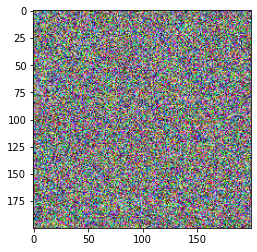

In [ ]:
plt.imshow(data_color.reshape(200,200,3));

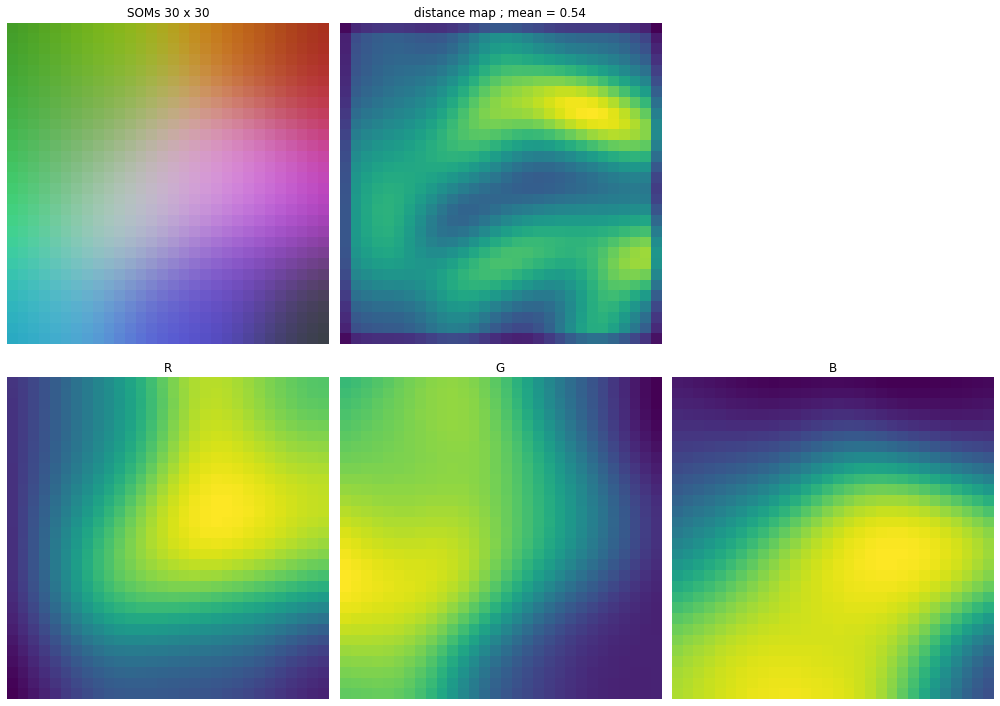

In [ ]:
nb, data_color, color_names = dat_color()

sigma = 8
learning_rate = 1
som, weights = train_som(data_color, sigma, learning_rate, 1000, size=(30,30))
PlotSOMs(data_color, som, weights)

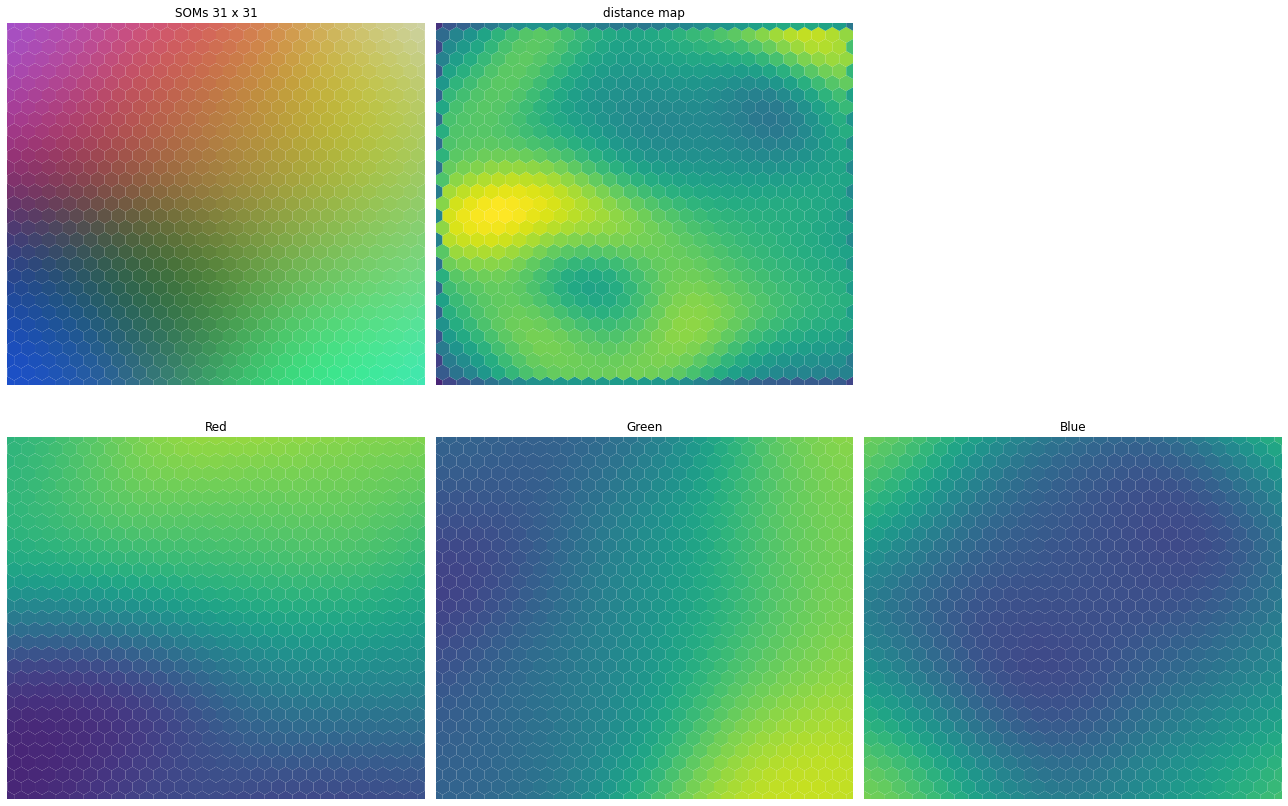

In [ ]:
sigma = 10
learning_rate = 1

som, weights = train_som(data_color, sigma, learning_rate, 5000, topology='hexagonal')
PlotSOMs(data_color, som, weights, color_names)

### Weird result

sigma = 12.0 ; learning rate 1.0 



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


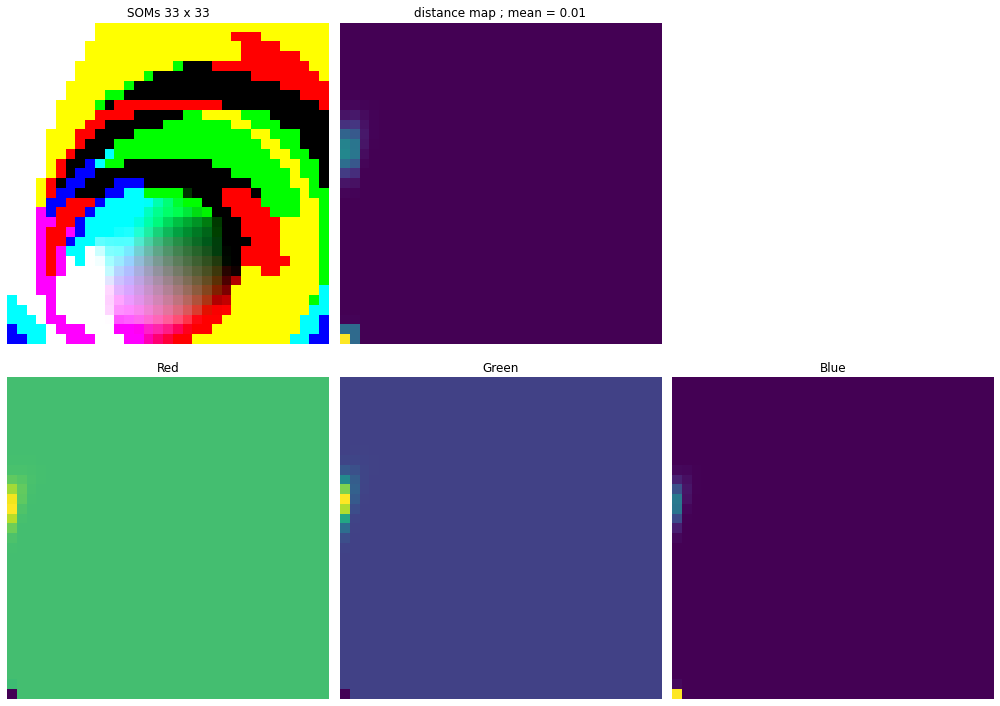

In [ ]:
sigma = 12
learning_rate = 1
print("sigma = %.1f ; learning rate %.1f \n" % (sigma, learning_rate))

som, weights = train_som(data_color, sigma, learning_rate, 1000)

som_color(data_color, som, weights, color_names)
# neighborhood function = bubble 

<a name="S3_4"></a>
## Errors

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


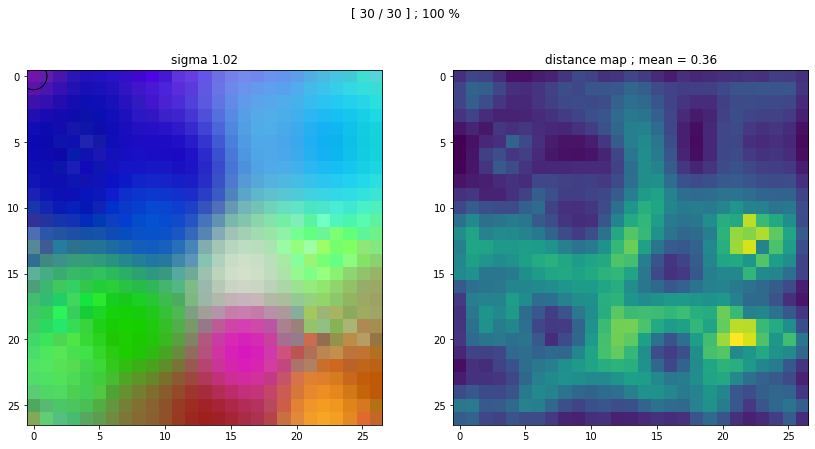

In [ ]:
nb, data_color, color_names = dat_color()
X_train, X_test = train_test_split(data_color, test_size=0.05)

sigma = 3
learning_rate = 2
iterations = 30
frequence = 1

som, weights, iter_x, q_error, q_error_val, t_error, mapmean, sig, learnR = train_and_get_error(X_train, X_test, 
                                    sigma, learning_rate, 
                                    iterations, frequence,
                                    topological_error=False)

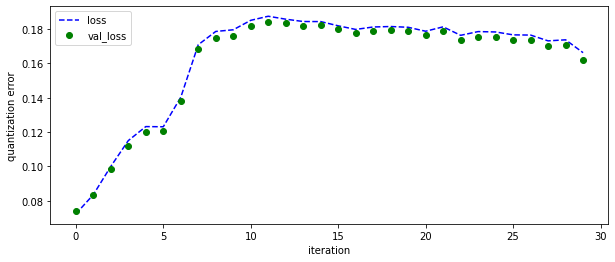

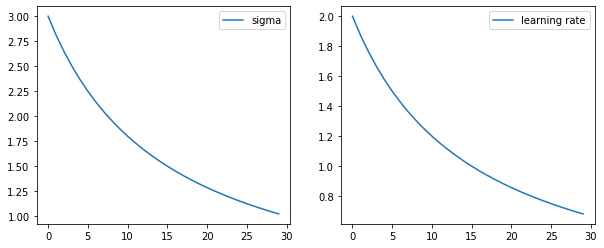

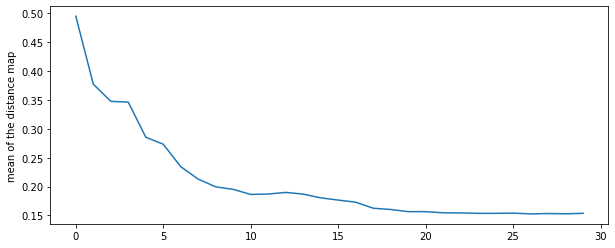

In [ ]:
plot_error(iter_x, q_error, q_error_val, mapmean, sig=sig, learnR=learnR, freq=frequence)

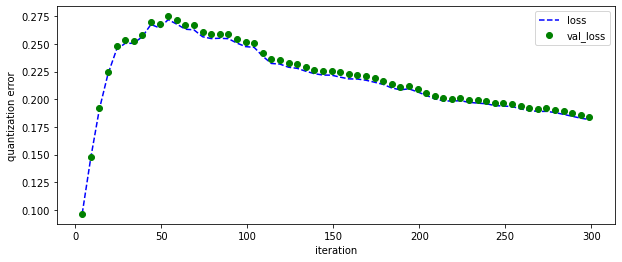

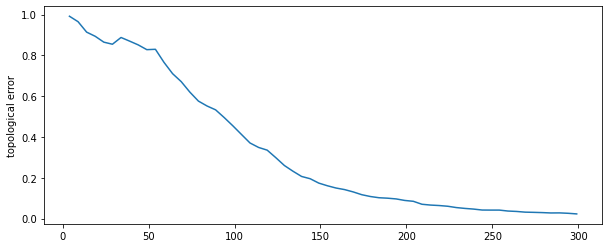

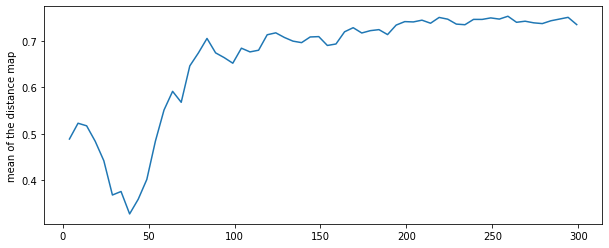

In [ ]:
plot_error(iter_x, q_error, q_error_val, mapmean, t_error=t_error)

## Errors fct sigma

In [ ]:
nb, data_color, color_names = dat_color(nb=40000)


nb_sigma=10
sigma = np.linspace(2,14,nb_sigma)
learning_rate = 1

q_error = np.zeros(nb_sigma)
t_error = np.zeros(nb_sigma)

W20 = []

for i, sig in enumerate(sigma):
    som, weights = train_som(data_color, sig, learning_rate, 1000, size=(30,30))
    W20.append(weights)
    q_error[i] = som.quantization_error(data_color)
    t_error[i] = som.topographic_error(data_color)
    print("\r",i+1, "/", nb_sigma, end='')

 10 / 10

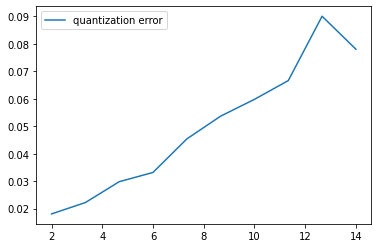

In [ ]:
plt.plot(sigma, q_error, label='quantization error')
plt.legend();

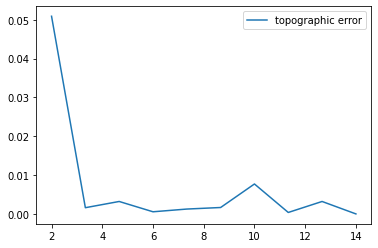

In [ ]:
plt.plot(sigma, t_error, label='topographic error')
plt.legend()

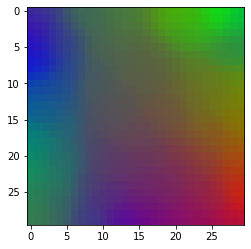

In [ ]:
plt.imshow(W20[0]);

<a name="S3_2"></a>
## Interactive SOMs

In [259]:
nb, data_color, color_names = dat_color()

### Rectangular

In [260]:
interactive_plot(data_color)

interactive(children=(FloatSlider(value=7.0, description='sigma', layout=Layout(height='40px', width='40%'), m…

### Hexagonal

In [262]:
interactive_plot(data_color, topology='hexagonal')

interactive(children=(FloatSlider(value=7.0, description='sigma', layout=Layout(height='40px', width='40%'), m…

## SOMperf


[SOMperf](https://github.com/FlorentF9/SOMperf) on github

In [ ]:
cd SOMperf

/content/drive/My Drive/Colab Notebooks/SOMperf


In [ ]:
from somperf.metrics import *
from somperf.utils.topology import rectangular_topology_dist

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.cluster.supervised module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics.cluster. Anything that cannot be imported from sklearn.metrics.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:22: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


In [ ]:
cd ..

/content/drive/My Drive/Colab Notebooks


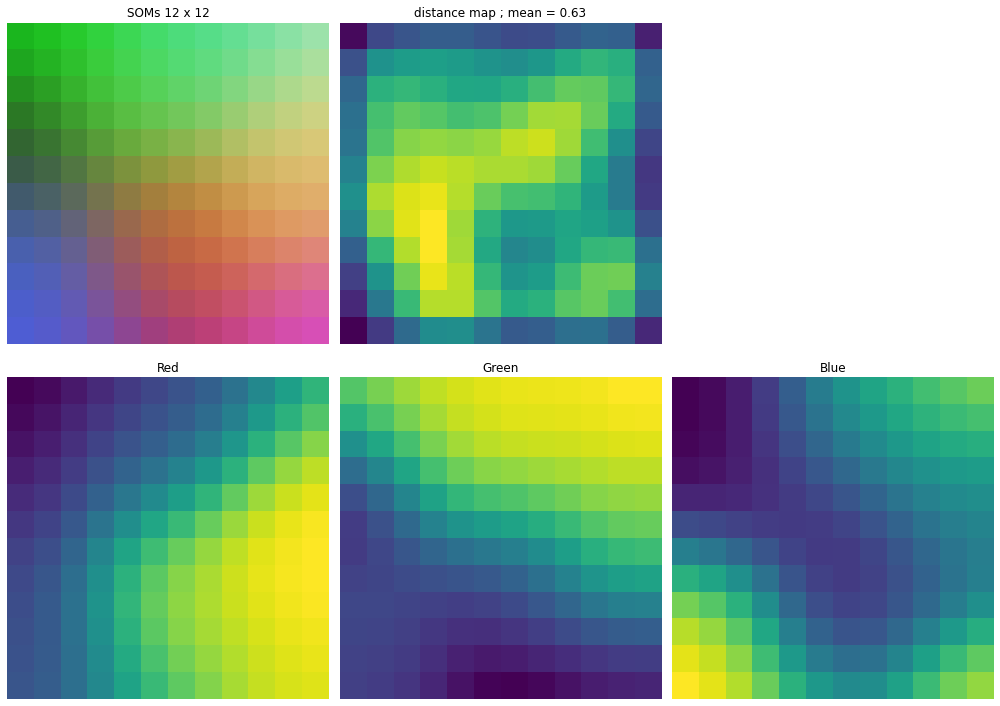

In [ ]:
nb, data_color, color_names = dat_color(nb=1000)

sigma = 4
learning_rate = 1

som, weights = train_som(data_color, sigma, learning_rate, 1000)
PlotSOMs(data_color, som, weights)

In [ ]:
w_r = weights.reshape(weights.shape[0]*weights.shape[1], -1)

In [ ]:
print("quantization error %.3f ; topographic error %.3f" %(
    som.quantization_error(data_color),
    som.topographic_error(data_color)))

quantization error 0.201 ; topographic error 0.015


In [ ]:
print("neighborhood preservation %.3f ; trustworthiness %.3f" %(
    neighborhood_preservation_trustworthiness(1, w_r, data_color)))

neighborhood preservation 0.724 ; trustworthiness 0.956


<a name="S3_3"></a>
## Heatmap, visible edges conditions

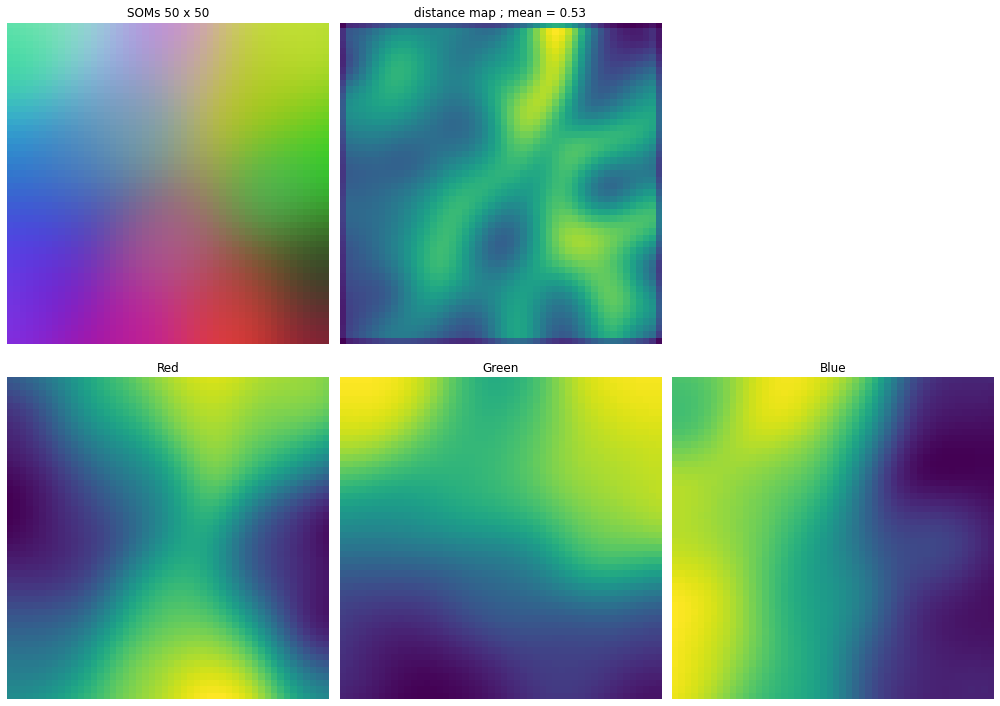

In [ ]:
nb, data_color, color_names = dat_color(nb=250000)

sigma = 9
learning_rate = 1

som, weights = train_som(data_color, sigma, learning_rate, 100)
PlotSOMs(data_color, som, weights, color_names)

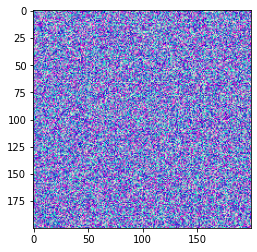

In [ ]:
NB = 40000
a = np.random.uniform(0,1,NB)
b = np.random.uniform(0,1,NB)
c = np.random.normal(.8,.05,NB)

c /= max(c)

abc = np.vstack([a,b,c]).T

plt.imshow(abc.reshape(200,200,3));

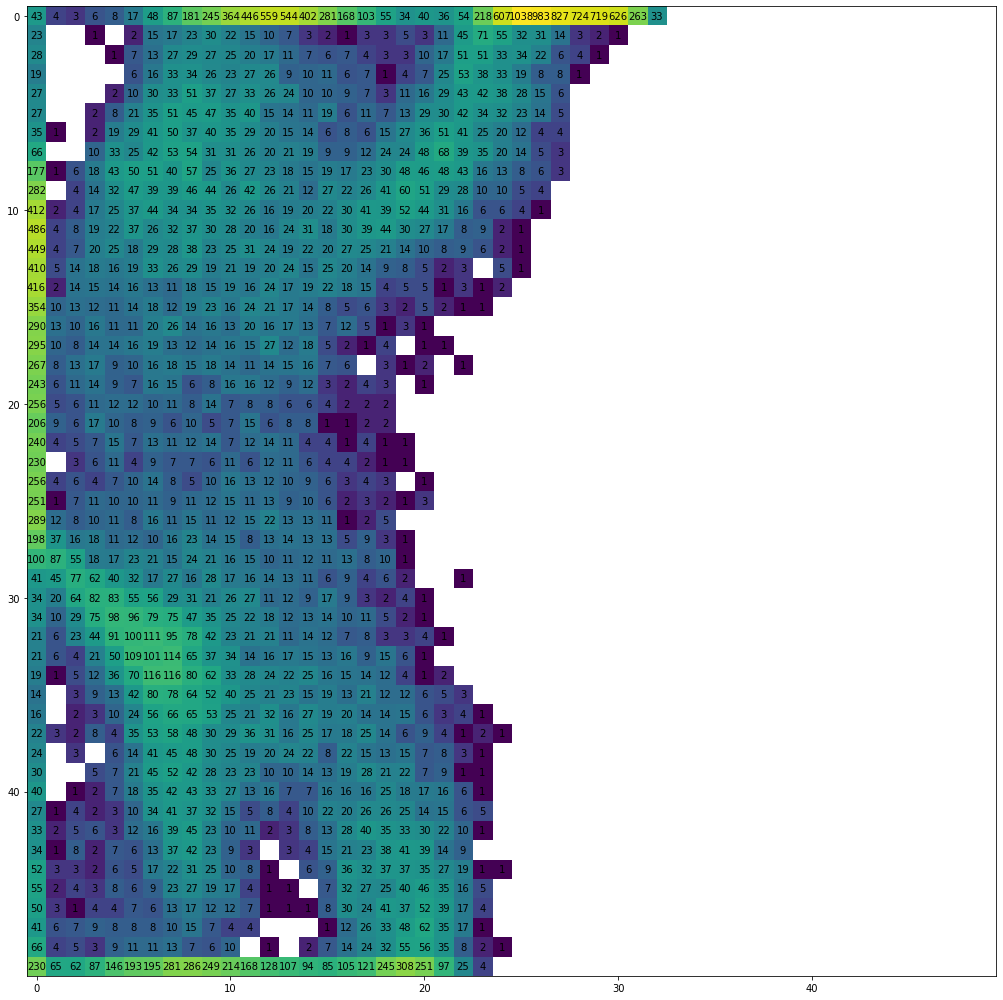

In [ ]:
Heatmap(som, abc) # abc -> dataset fortement bleu -> hitmap tres proche de blue_weights

### Coord inverted example

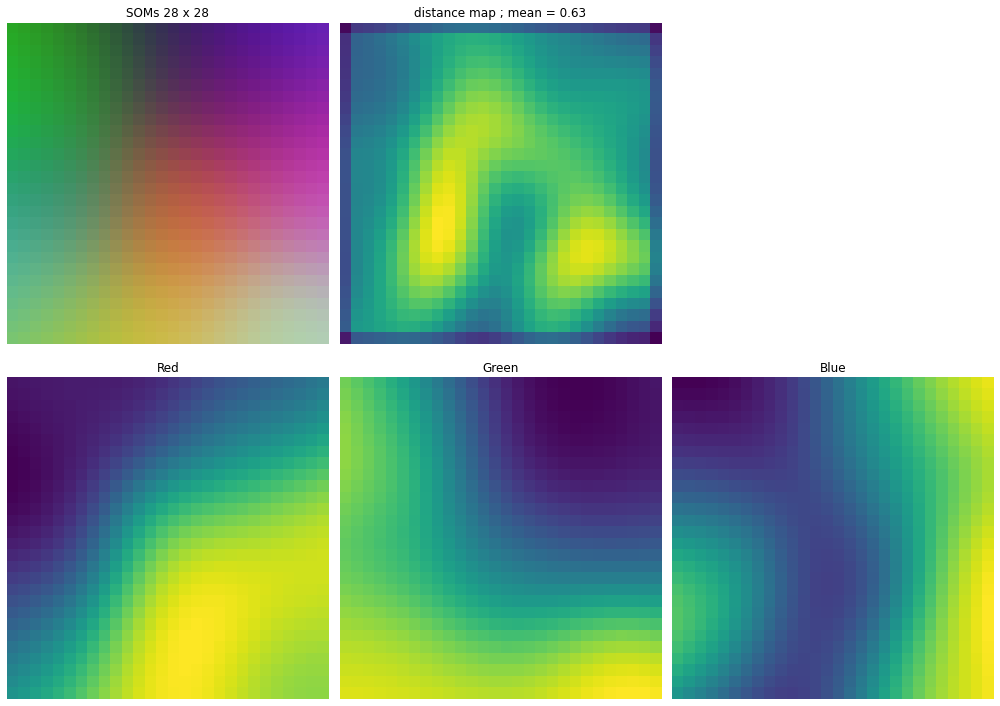

In [ ]:
nb, data_color, color_names = dat_color()

sigma = 9
learning_rate = 1

som, weights = train_som(data_color, sigma, learning_rate, 1000)
PlotSOMs(data_color, som, weights)

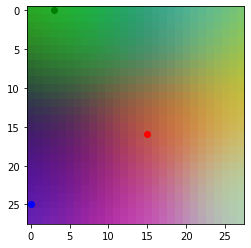

In [ ]:
w3 = weights.copy()
for i in range(3):
    w3[:,:,i]=w3[:,:,i].T

plt.imshow(w3)

r,g,b = [[1,0,0], [0,1,0], [0,0,1]]

plt.scatter(*som.winner(r), color='red')
plt.scatter(*som.winner(g), color='green')
plt.scatter(*som.winner(b), color='blue');

In [ ]:
som.winner(g)

(3, 0)

(array([3]), array([0]))


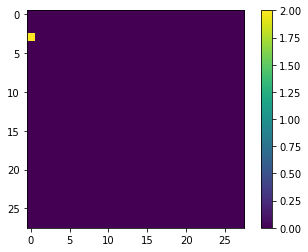

In [ ]:
print(np.where(som.activation_response([g,g])))

plt.imshow(som.activation_response([g,g]))
plt.colorbar();

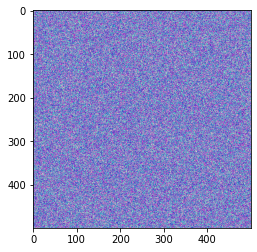

In [ ]:
NB = 250000
a = np.random.uniform(0,1,NB)
b = np.random.uniform(0,1,NB)
c = np.random.normal(.8,.05,NB)
c /= max(c)

abc = np.vstack([a,b,c]).T

plt.imshow(abc.reshape(500,500,3));

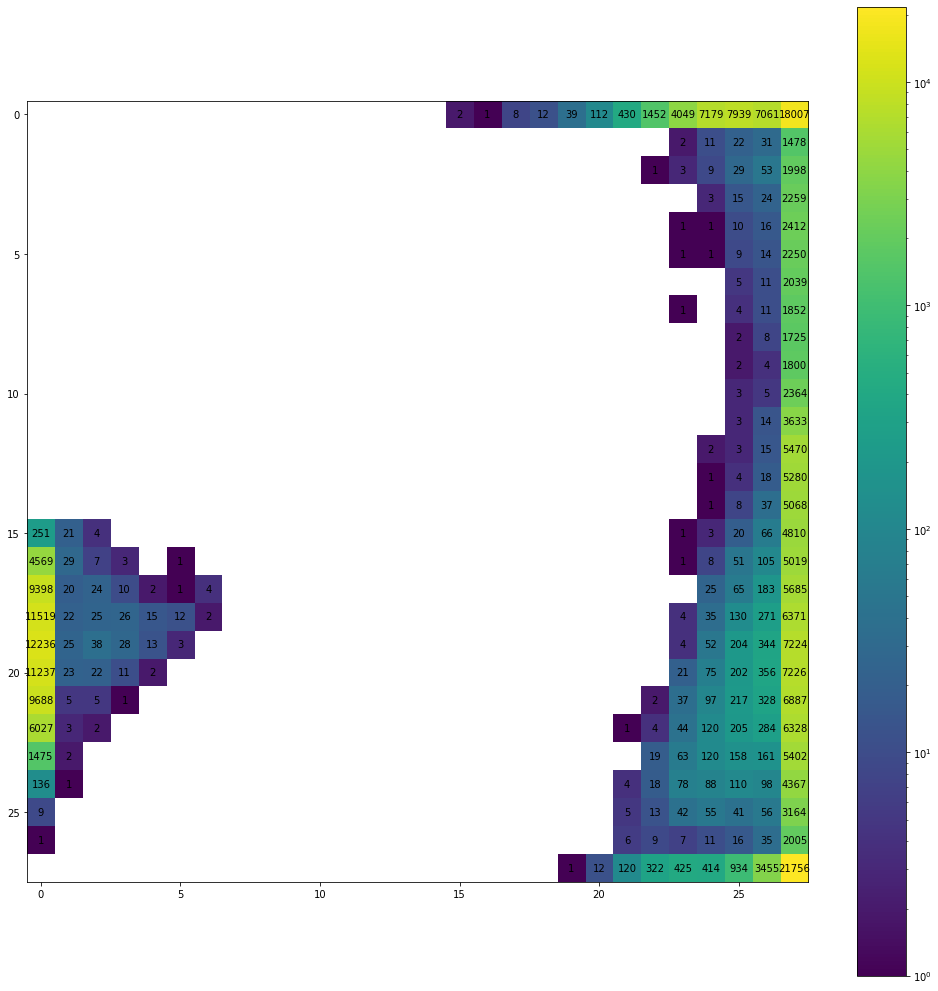

In [ ]:
Hitmap(som, abc) # abc -> dataset fortement bleu -> hitmap tres proche de blue_weights

## Tests heatmap, uniform normalized dataset

### RGB A

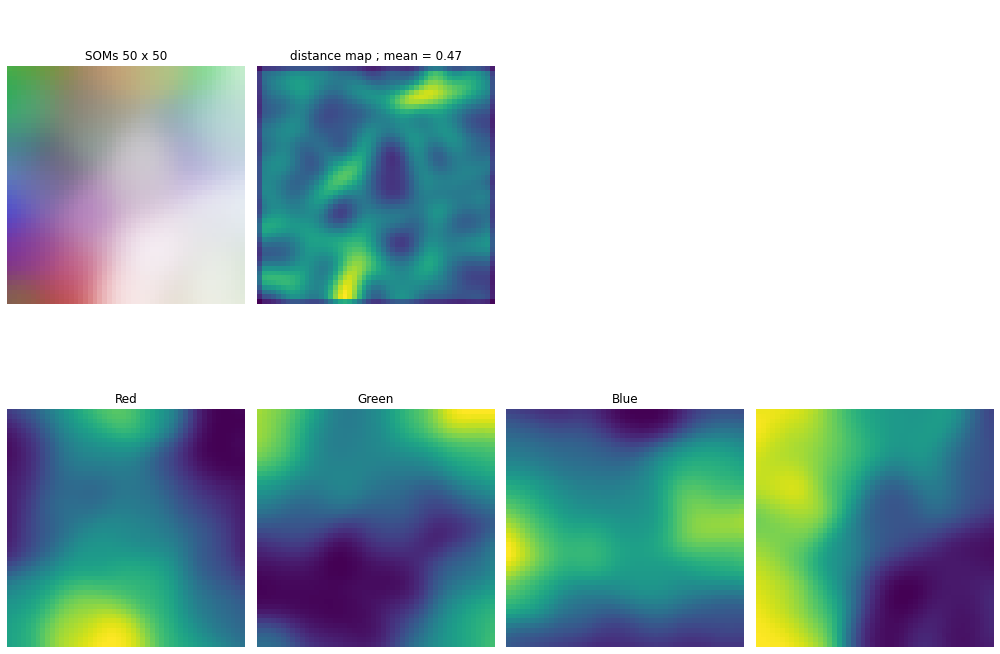

In [ ]:
nb=250000
dat1 = np.random.uniform(0,1,nb)
dat2 = np.random.uniform(0,1,nb)
dat3 = np.random.uniform(0,1,nb)

data_color = np.vstack((dat1,dat2,dat3)).T


# normalize each row
sum_of_rows = data_color.sum(axis=1)
data_color_norm = data_color / sum_of_rows[:, np.newaxis]


# adding 4th column for the intensity
dat4 = np.random.uniform(0,1,nb)
#dat4 = np.random.normal(.5, .1, nb)
data_color = np.vstack((data_color_norm.T, dat4)).T


# SOMs
sigma = 7
learning_rate = 1

som, weights = train_som(data_color, sigma, learning_rate, 5000)
som_color(data_color, som, weights, color_names)

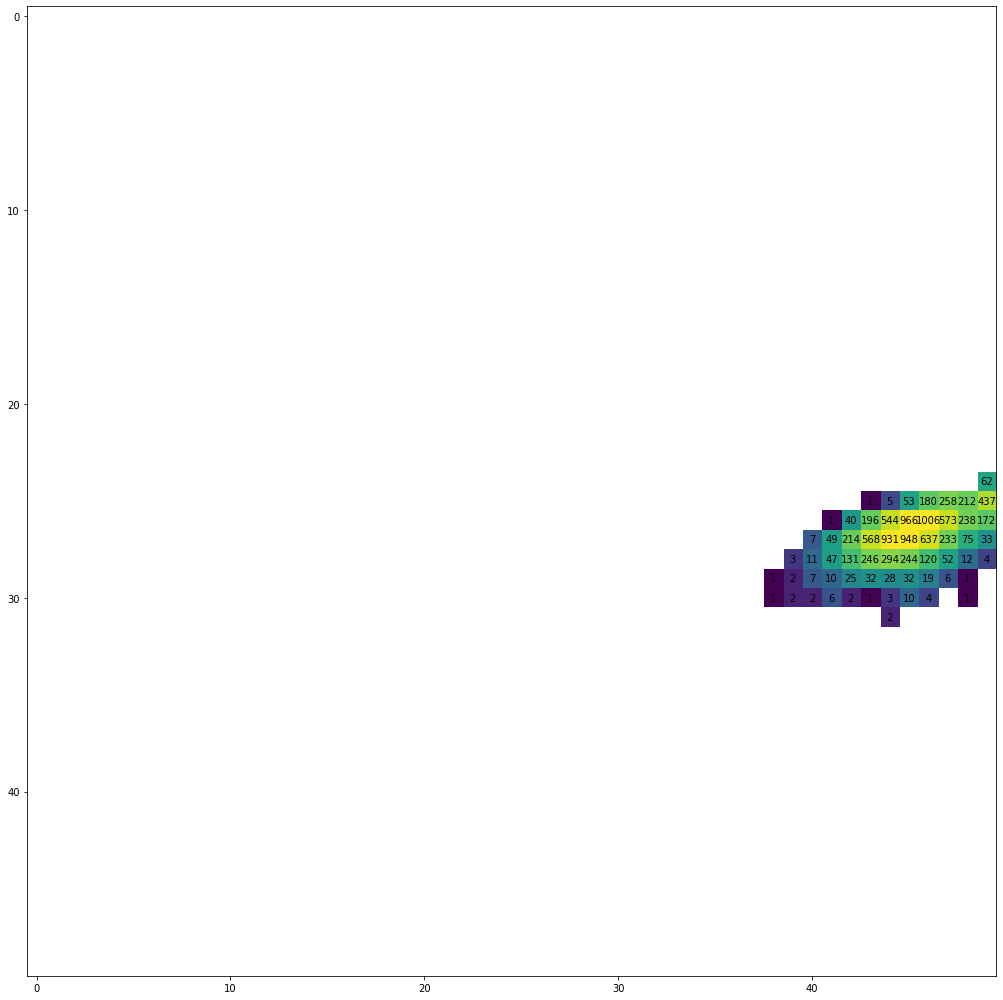

In [ ]:
NB = 10000

a = np.random.normal(.2,.05,NB) # red
b = np.random.normal(.2,.05,NB) # green
c = np.random.normal(.7,.05,NB) # blue ----

abc = np.vstack([a,b,c]).T

# normalize each row
sum_of_rows = abc.sum(axis=1)
abc_norm = abc / sum_of_rows[:, np.newaxis]

# adding 4th column for the intensity
dat4 = np.random.uniform(0,.1,NB)
abc = np.vstack((abc_norm.T, dat4)).T


Heatmap(som, abc)

### RGB

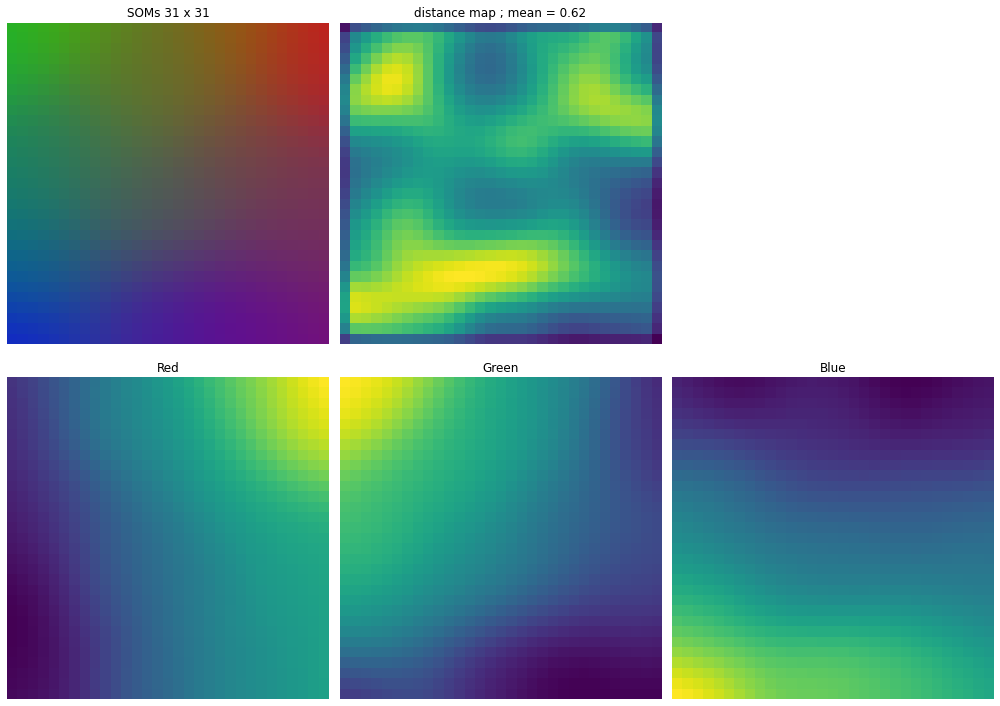

In [ ]:
nb = 40000 ; nb_reshape = int(np.sqrt(nb))

dat1 = np.random.uniform(0,1,nb)
dat2 = np.random.uniform(0,1,nb)
dat3 = np.random.uniform(0,1,nb)

data_color = np.vstack((dat1,dat2,dat3)).T


# normalize each row
sum_of_rows = data_color.sum(axis=1)
data_color = data_color / sum_of_rows[:, np.newaxis]


# SOMs
sigma = 7
learning_rate = 1

som, weights = train_som(data_color, sigma, learning_rate, 5000)
PlotSOMs(data_color, som, weights)

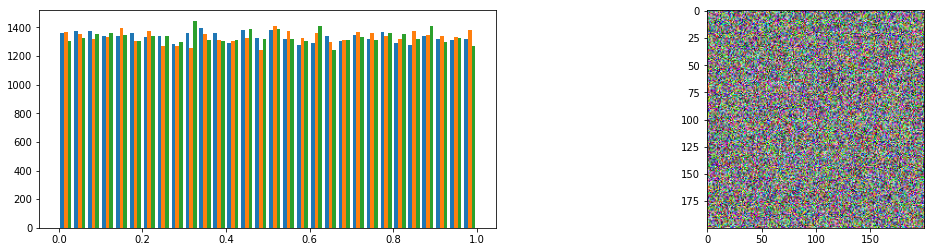

In [ ]:
# before normalization
plt.figure(figsize=(18,4))
plt.subplot(121)
plt.hist(np.vstack((dat1,dat2,dat3)).T, bins=30)
plt.subplot(122)
plt.imshow(np.vstack((dat1,dat2,dat3)).T.reshape(nb_reshape,nb_reshape,3))
plt.show()

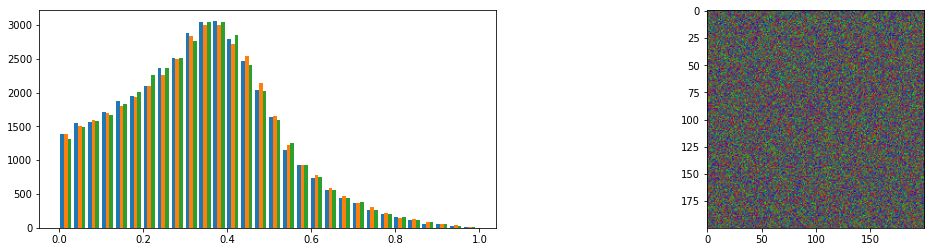

In [ ]:
# after normalization
plt.figure(figsize=(18,4))
plt.subplot(121)
plt.hist(data_color, bins=30)
plt.subplot(122)
plt.imshow(data_color.reshape(nb_reshape,nb_reshape,3))
plt.show()

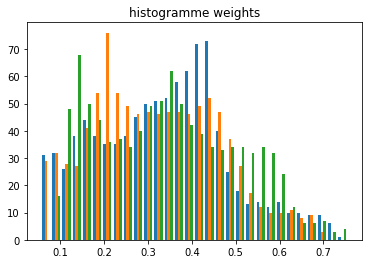

In [ ]:
plt.title("histogramme weights")
plt.hist(weights.reshape( np.prod(weights.shape[0:2]) , 3), bins=30 );

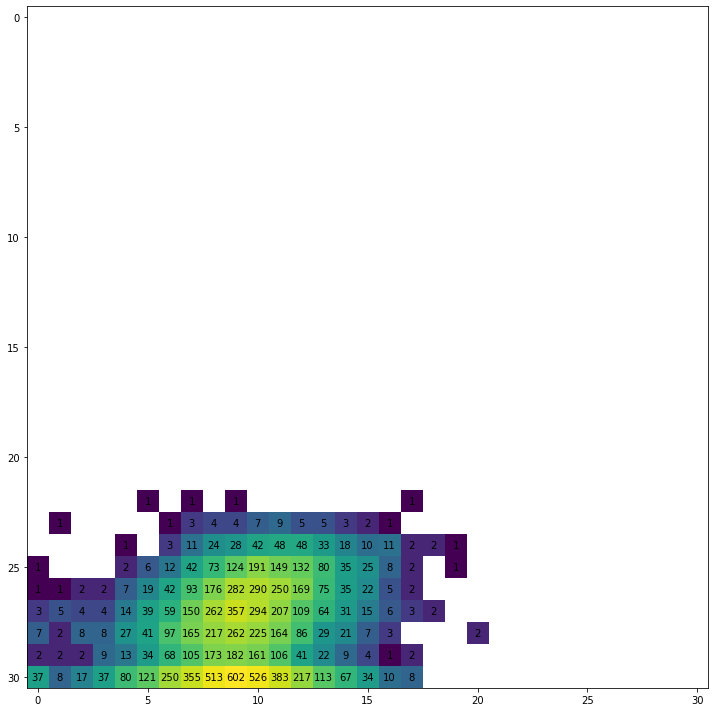

In [ ]:
NB = 10000

a = np.random.normal(.2,.05,NB)
b = np.random.normal(.2,.05,NB)
c = np.random.normal(.6,.05,NB)

abc = np.vstack([a,b,c]).T

# normalize each row
sum_of_rows = abc.sum(axis=1)
abc = abc / sum_of_rows[:, np.newaxis]

Heatmap(som, abc, figsize=(10,10))

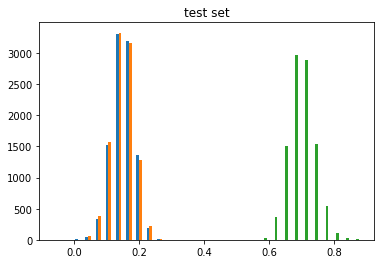

In [ ]:
plt.title("test set")
plt.hist(abc,bins=30); # blue at the right

#### Other normalizations

In [ ]:
nb_test=250000

coord=[]
for i in range(nb_test):
    theta = np.random.uniform(np.pi)
    phi = np.random.uniform(np.pi*2)  

    x = np.sin(theta)*np.cos(phi)
    y = np.sin(theta)*np.sin(phi)
    z = np.cos(theta)

    coord.append([x,y,z])

coord = np.abs(coord)

In [ ]:
coord # normalisé sqrt(x^2+...)=1 -> pas bon

array([[0.1416165 , 0.89680714, 0.41914404],
       [0.17808581, 0.29994478, 0.93718652],
       [0.53796342, 0.04490287, 0.8417714 ],
       ...,
       [0.86234148, 0.23444783, 0.44877766],
       [0.42304395, 0.78970105, 0.44430402],
       [0.75317596, 0.6567413 , 0.03764086]])

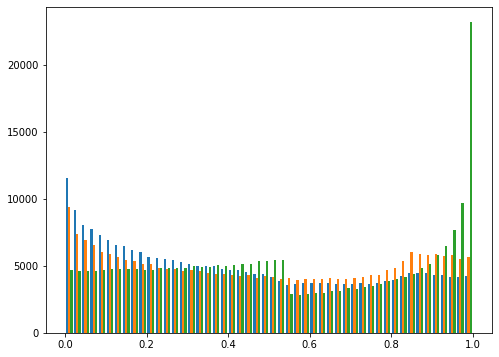

In [ ]:
plt.figure(figsize=(8,6))
plt.hist(coord, bins=50);

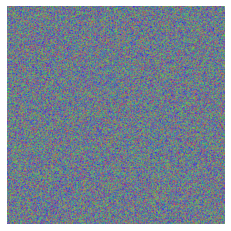

In [ ]:
plt.imshow(coord.reshape(500,500,3))
plt.axis('off');

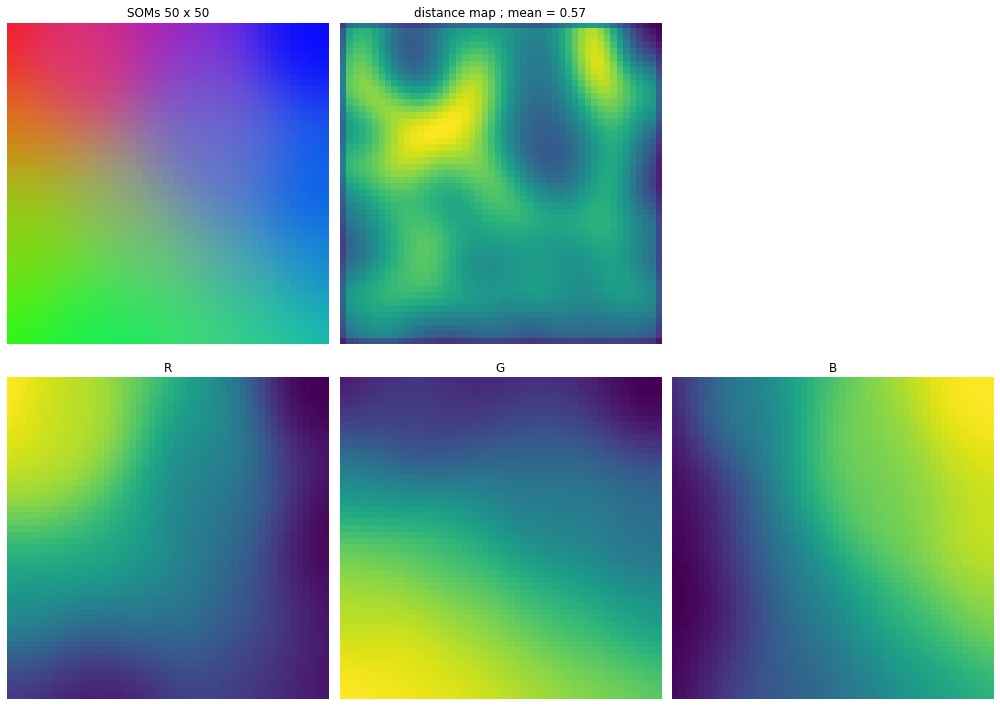

In [ ]:
# SOMs
sigma = 10
learning_rate = 1

som_coord, weights_coord = train_som(coord, sigma, learning_rate, 2000)
PlotSOMs(coord, som_coord, weights_coord)

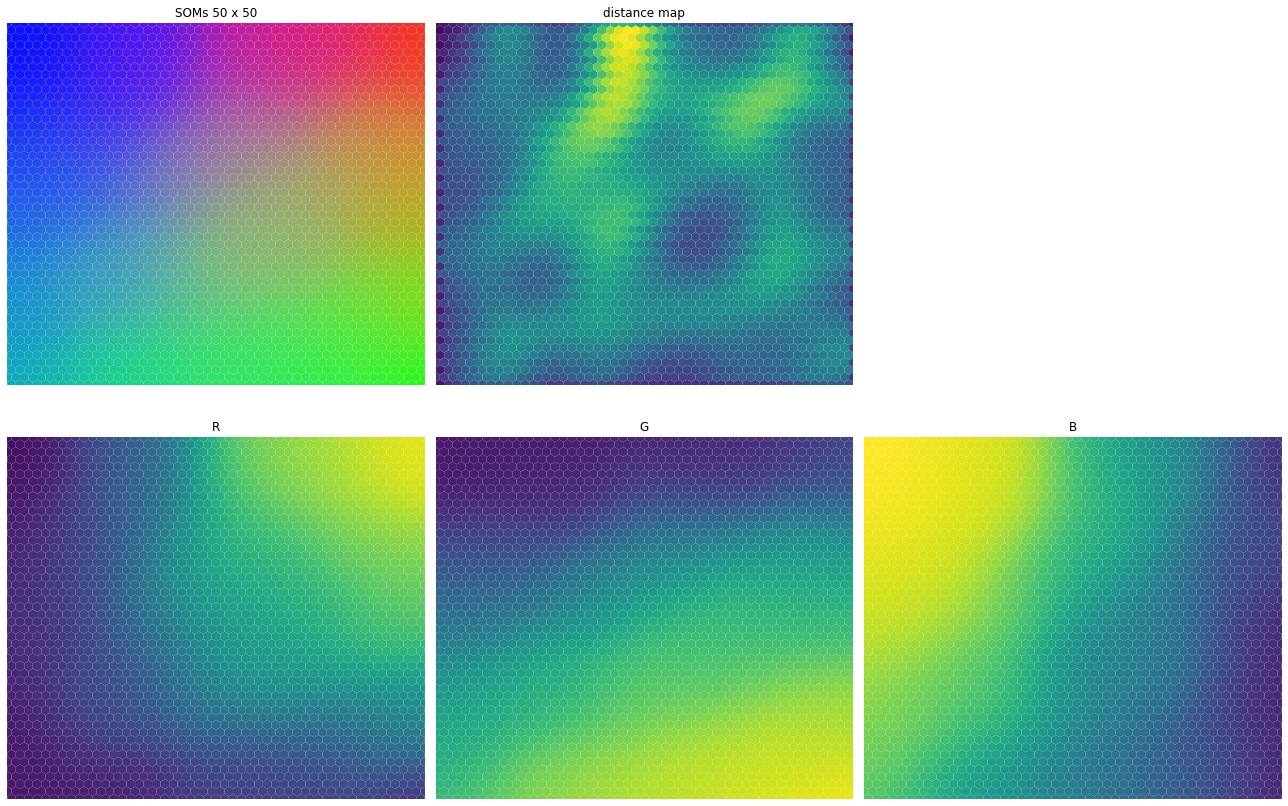

In [ ]:
# SOMs
sigma = 9
learning_rate = 1

som_coord, weights_coord = train_som(coord, sigma, learning_rate, 1000, topology='hexagonal')
PlotSOMs(coord, som_coord, weights_coord, topology='hexagonal')

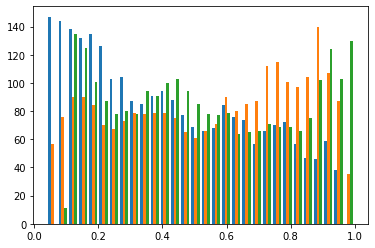

In [ ]:
plt.hist(weights_coord.reshape( np.prod(weights_coord.shape[0:2]) , 3),bins=30);

In [ ]:
NB = 10000

a = np.random.normal(.2,.05,NB) # red
b = np.random.normal(.2,.05,NB) # green
c = np.random.normal(.7,.05,NB) # blue ----

abc = np.vstack([a,b,c]).T

# normalize each row
sum_of_rows = abc.sum(axis=1)
abc = abc / sum_of_rows[:, np.newaxis]

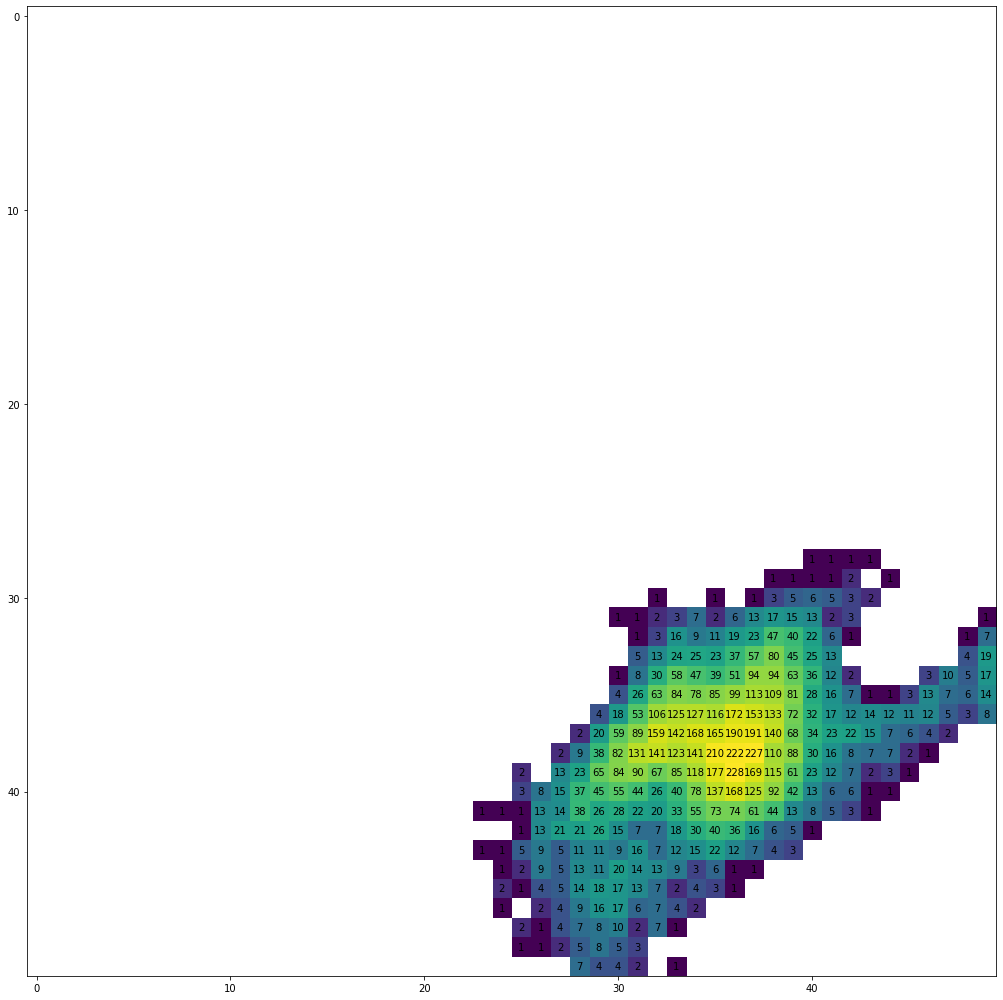

In [ ]:
Heatmap(som_coord, abc, hist_vars=False)

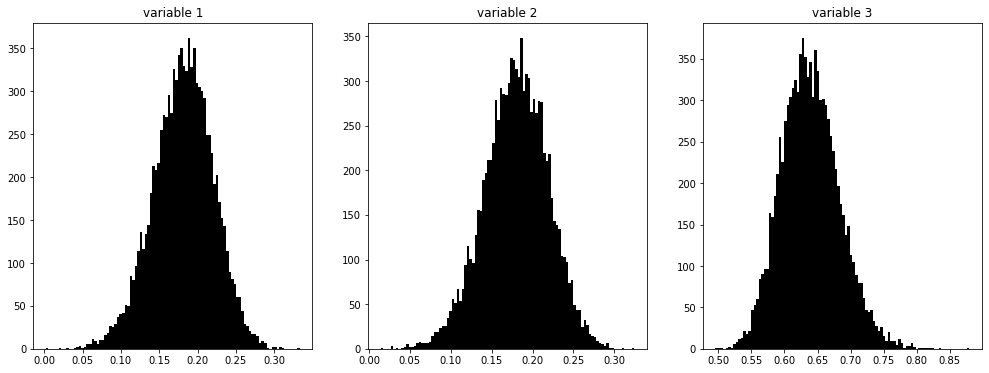

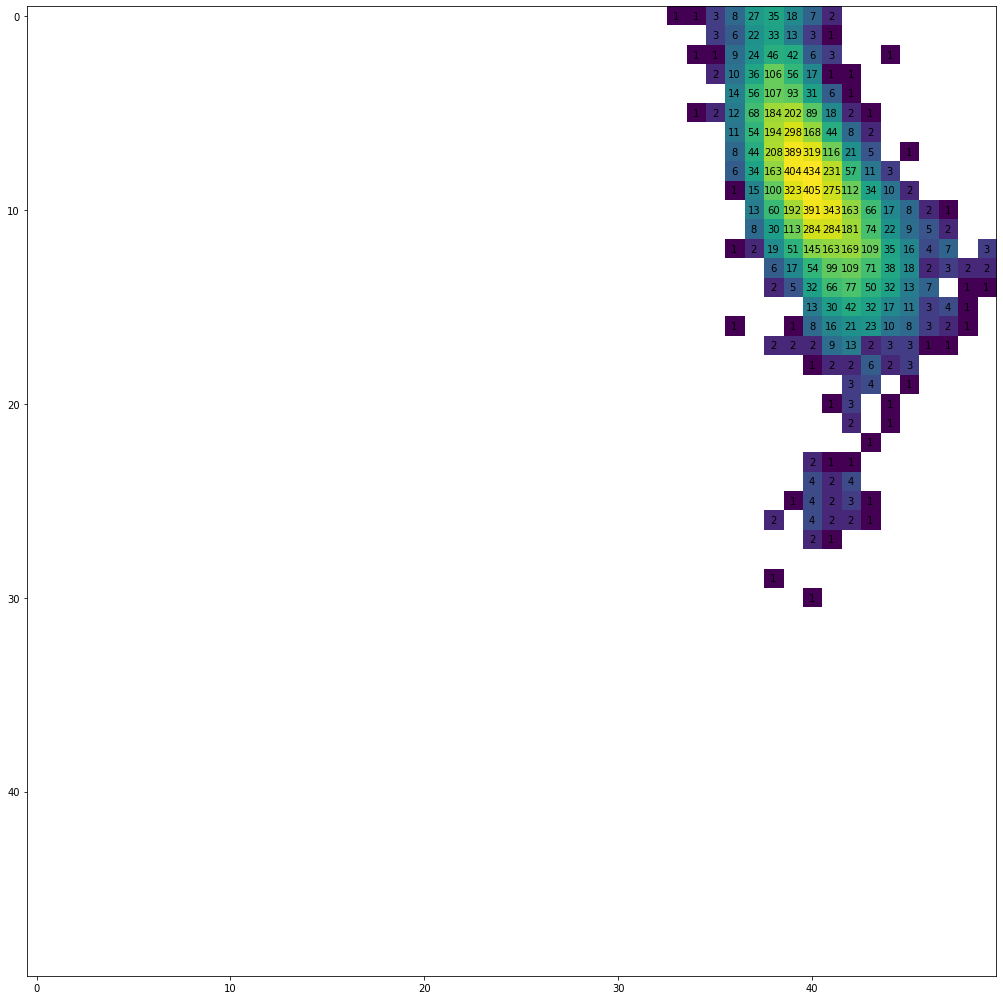

In [ ]:
Heatmap(som_coord, abc)

<a name="S3_5"></a>
## Tests normalizations

### Sklearn quantile_transform

In [ ]:
from sklearn.preprocessing import quantile_transform

In [ ]:
nb=40000

rng = np.random.RandomState(0)
X = np.sort(rng.normal(loc=0.5, scale=0.25, size=(nb, 3)), axis=0)
data_transform = quantile_transform(X, n_quantiles=100, random_state=0, copy=True)

In [ ]:
data_transform

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.49586071e-04, 9.27825821e-04, 4.42303718e-03],
       [5.55039666e-04, 2.90104163e-03, 4.98210039e-03],
       ...,
       [9.97948379e-01, 9.97319123e-01, 9.98482436e-01],
       [9.98212166e-01, 9.97510766e-01, 9.98871672e-01],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00]])

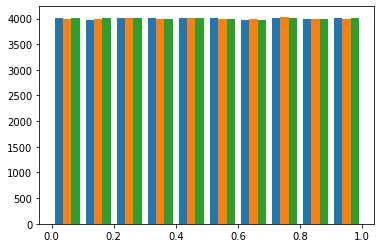

In [ ]:
plt.hist(data_transform);

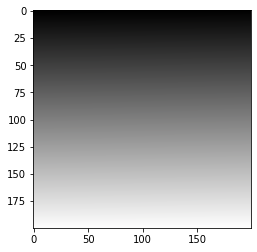

In [ ]:
plt.imshow(data_transform.reshape(200,200,3));

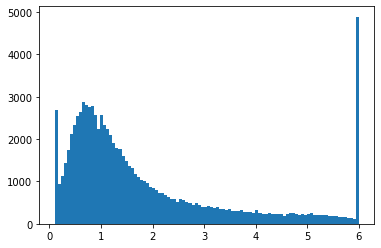

In [ ]:
plt.hist(data_cs['sersicfit'][:,2], bins=100);

In [ ]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import MinMaxScaler

In [ ]:
X = data_cs['sersicfit'][:,2].reshape(1, -1).copy()
transformer = RobustScaler(with_centering=False, quantile_range=(25,75)).fit(X)
transformer

RobustScaler(copy=True, quantile_range=(25, 75), with_centering=False,
             with_scaling=True)

In [ ]:
X = transformer.transform(X)
X

array([[0.99394162, 2.39859108, 0.93862006, ..., 2.55665395, 1.98972413,
        5.87570225]])

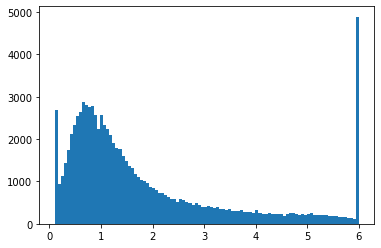

In [ ]:
plt.hist(X[0],bins=100);

In [ ]:
X = data_cs['sersicfit'][:,2].reshape(1, -1).copy()
transformer = Normalizer(norm='max').fit(X)  # fit does nothing.
transformer

Normalizer(copy=True, norm='max')

In [ ]:
X = transformer.transform(X)

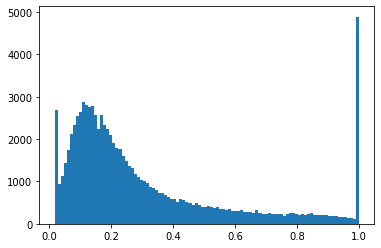

In [ ]:
plt.hist(X[0],bins=100);

In [ ]:
X = data_cs['sersicfit'][:,2].reshape(1, -1).copy()
qt = QuantileTransformer(n_quantiles=1, random_state=0)
X = qt.fit_transform(X)

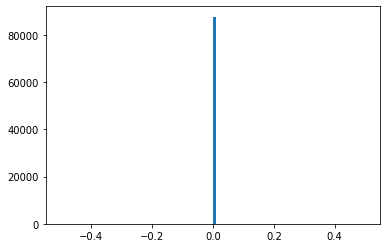

In [ ]:
plt.hist(X[0], bins=100);

In [ ]:
X = data_cs['sersicfit'][:,2].reshape(-1, 1).copy()
scaler = MinMaxScaler()
print(scaler.fit(X))

MinMaxScaler(copy=True, feature_range=(0, 1))


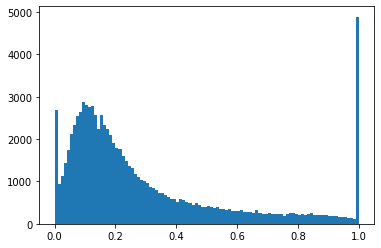

In [ ]:
plt.hist(scaler.transform(X),bins=100);

<a name="S3_6"></a>
## GHSOM

[GHSOM](https://github.com/enry12/growing_hierarchical_som) on github

In [ ]:
cd growing_hierarchical_som

/content/drive/My Drive/Colab Notebooks/growing_hierarchical_som


In [ ]:
from GHSOM import GHSOM

In [ ]:
cd ..

/content/drive/My Drive/Colab Notebooks


In [ ]:
nb, data_color, color_names = dat_color()

som = GHSOM(data_color, t1=0.3, t2=0.002, learning_rate=0.15, decay=0.9, gaussian_sigma=1.2)
ghsom = som.train()

print(ghsom)

[Elapsed Time: 0:00:42] |######################################| (25000/25000) 

position (0, 0) -- map dimensions (1, 1, 3) -- input dataset 25000 element(s) -- level 0 
	position (0, 0) -- map dimensions (2, 2, 3) -- input dataset 5785 element(s) -- level 1 
		position (0, 0) -- map dimensions (2, 2, 3) -- input dataset 1572 element(s) -- level 2 
			position (0, 0) -- map dimensions (2, 2, 3) -- input dataset 442 element(s) -- level 3 
				position (0, 0) -- map dimensions (2, 2, 3) -- input dataset 101 element(s) -- level 4 
				position (0, 1) -- map dimensions (2, 2, 3) -- input dataset 115 element(s) -- level 4 
				position (1, 0) -- map dimensions (2, 2, 3) -- input dataset 118 element(s) -- level 4 
				position (1, 1) -- map dimensions (2, 2, 3) -- input dataset 108 element(s) -- level 4 
			position (0, 1) -- map dimensions (2, 2, 3) -- input dataset 393 element(s) -- level 3 
				position (0, 0) -- map dimensions (2, 2, 3) -- input dataset 96 element(s) -- level 4 
				position (0, 1) -- map dimensions (2, 2, 3) -- input dataset 99 element(s) -- level 

In [ ]:
gmap = ghsom.child_map

In [ ]:
"""
def repr(gmap, level):
    gap = '\t'*level
    _printable = "{}level {} \n".format(
        gap,
        level
    )

    if (level==2):
        return _printable

    if gmap.child_map is not None:

        for neuron in gmap.child_map.neurons:
            print("------ lvl %d ------"%level)
            print(neuron)
            print(gmap.child_map.weights_map)

            _printable += repr(gmap, level+1)
            break
    return _printable
"""

In [ ]:
def repr(gmap, weights, level):

    if (level==3
        #gmap.child_map is None
        ):
        return weights

    if gmap.child_map is not None:

        for neuron in gmap.child_map.neurons:
            print("\n------ lvl %d ------"%level)
            print("neuron", neuron)
            print(gmap.child_map.weights_map)
            
            weights.append(gmap.child_map.weights_map[0][neuron])
            print("weights",weights)
            
            weights.append( repr(gmap, weights, level+1) )
            gmap = gmap.child_map.neurons
            break
    return weights

In [ ]:
type(ghsom)

neuron.neuron.Neuron

In [ ]:
type(ghsom.child_map.neurons)

dict

In [ ]:
weights = repr(ghsom, [], 0)


------ lvl 0 ------
neuron (0, 0)
[array([[[0.73384183, 0.30032126, 0.70846432],
        [0.31541928, 0.23491573, 0.38106502]],

       [[0.43345378, 0.736815  , 0.74613088],
        [0.56223111, 0.74640985, 0.22592993]]])]
weights [array([0.73384183, 0.30032126, 0.70846432])]

------ lvl 1 ------
neuron (0, 0)
[array([[[0.73384183, 0.30032126, 0.70846432],
        [0.31541928, 0.23491573, 0.38106502]],

       [[0.43345378, 0.736815  , 0.74613088],
        [0.56223111, 0.74640985, 0.22592993]]])]
weights [array([0.73384183, 0.30032126, 0.70846432]), array([0.73384183, 0.30032126, 0.70846432])]

------ lvl 2 ------
neuron (0, 0)
[array([[[0.73384183, 0.30032126, 0.70846432],
        [0.31541928, 0.23491573, 0.38106502]],

       [[0.43345378, 0.736815  , 0.74613088],
        [0.56223111, 0.74640985, 0.22592993]]])]
weights [array([0.73384183, 0.30032126, 0.70846432]), array([0.73384183, 0.30032126, 0.70846432]), array([0.73384183, 0.30032126, 0.70846432])]


### gmap

In [ ]:
pos0_0 = gmap.neurons[0,0]

In [ ]:
neurrr = gmap.neurons

In [ ]:
pos0_0_0 = pos0_0.child_map.neurons[0,0]
pos0_0_0

position (0, 0) -- map dimensions (2, 2, 3) -- input dataset 1220 element(s) -- level 0 
	position (0, 0) -- map dimensions (2, 2, 3) -- input dataset 268 element(s) -- level 1 
		position (0, 0) -- map dimensions (2, 2, 3) -- input dataset 71 element(s) -- level 2 
		position (0, 1) -- map dimensions (2, 2, 3) -- input dataset 72 element(s) -- level 2 
		position (1, 0) -- map dimensions (2, 2, 3) -- input dataset 60 element(s) -- level 2 
		position (1, 1) -- map dimensions (2, 2, 3) -- input dataset 65 element(s) -- level 2 
	position (0, 1) -- map dimensions (2, 2, 3) -- input dataset 299 element(s) -- level 1 
		position (0, 0) -- map dimensions (2, 2, 3) -- input dataset 91 element(s) -- level 2 
		position (0, 1) -- map dimensions (2, 2, 3) -- input dataset 68 element(s) -- level 2 
		position (1, 0) -- map dimensions (2, 2, 3) -- input dataset 67 element(s) -- level 2 
		position (1, 1) -- map dimensions (2, 2, 3) -- input dataset 73 element(s) -- level 2 
	position (1, 0) -- m

In [ ]:
pos0_0_0_0 = pos0_0_0.child_map.neurons[0,0]
pos0_0_0_0

position (0, 0) -- map dimensions (2, 2, 3) -- input dataset 268 element(s) -- level 0 
	position (0, 0) -- map dimensions (2, 2, 3) -- input dataset 71 element(s) -- level 1 
	position (0, 1) -- map dimensions (2, 2, 3) -- input dataset 72 element(s) -- level 1 
	position (1, 0) -- map dimensions (2, 2, 3) -- input dataset 60 element(s) -- level 1 
	position (1, 1) -- map dimensions (2, 2, 3) -- input dataset 65 element(s) -- level 1 

In [ ]:
pos0_0_0_0_all = pos0_0_0_0.child_map
pos0_0_0_0_all.weights_map

[array([[[0.41207718, 0.5767142 , 0.55124066],
         [0.28912619, 0.61535766, 0.5637153 ]],
 
        [[0.44100227, 0.57605806, 0.62626278],
         [0.30449188, 0.61564421, 0.68280996]]])]

In [ ]:
pos0_0_0_0_0 = pos0_0_0_0.child_map.neurons[0,0]
pos0_0_0_0_0

position (0, 0) -- map dimensions (2, 2, 3) -- input dataset 71 element(s) -- level 0 

In [ ]:
pos0_0_0_0_0._Neuron__weight_map[0]

array([[[0.41207718, 0.5767142 , 0.55124066],
        [0.28912619, 0.61535766, 0.5637153 ]],

       [[0.44100227, 0.57605806, 0.62626278],
        [0.30449188, 0.61564421, 0.68280996]]])

In [ ]:
for i in gmap.neurons.keys():
    print(i)

(0, 0)
(0, 1)
(1, 0)
(1, 1)


### tab weights

In [ ]:
import matplotlib.gridspec as gridspec

In [ ]:
fig = plt.figure(figsize=(8,8))
outer = gridspec.GridSpec(2, 2, wspace=0., hspace=0.)

for i in range(4):
    inner = gridspec.GridSpecFromSubplotSpec(2, 2,
                    subplot_spec=outer[i], wspace=0., hspace=0.)

    for j in range(4):
        ax = plt.Subplot(fig, inner[j])
        t = ax.text(0.5,0.5, 'outer=%d, inner=%d' % (i,j))
        t.set_ha('center')
        ax.set_xticks([])
        ax.set_yticks([])
        fig.add_subplot(ax)

fig.show()

In [ ]:
lvl_0 = np.zeros((2,2),dtype=object)
tab_weights = []

idx1=-1
for i in gmap.neurons.keys():
    lvl_0[i] = gmap.neurons[i]
    gmap_1 = lvl_0[i].child_map
    idx1+=1

    idx2=-1
    for m in np.concatenate(gmap_1.weights_map[0]):
        idx2+=1
        tab_weights.append([idx1,idx2,m])

tab_weights = np.array(tab_weights)
print(tab_weights.shape)
tab_weights

(16, 3)


array([[0, 0, array([0.52571697, 0.20877727, 0.79427922])],
       [0, 1, array([0.85121238, 0.18986697, 0.8331853 ])],
       [0, 2, array([0.82107975, 0.51109716, 0.70590665])],
       [0, 3, array([0.85604511, 0.19571159, 0.3502901 ])],
       [1, 0, array([0.43259709, 0.20578476, 0.42021136])],
       [1, 1, array([0.54106589, 0.19611846, 0.12573268])],
       [1, 2, array([0.15090118, 0.18873863, 0.6730285 ])],
       [1, 3, array([0.15923283, 0.35587744, 0.26135234])],
       [2, 0, array([0.48254309, 0.76068745, 0.72818485])],
       [2, 1, array([0.24749082, 0.53874479, 0.84727972])],
       [2, 2, array([0.81493589, 0.86634655, 0.81620095])],
       [2, 3, array([0.12434541, 0.81241713, 0.66136908])],
       [3, 0, array([0.5308    , 0.72755129, 0.24840269])],
       [3, 1, array([0.84154898, 0.80324239, 0.29096683])],
       [3, 2, array([0.19534749, 0.7846272 , 0.17617142])],
       [3, 3, array([0.78067388, 0.51192669, 0.14921713])]], dtype=object)

In [ ]:
tab16_3 = np.array(tab_weights[:,-1].tolist())
tab16_2x = tab16_3.reshape(4,2,2,3)

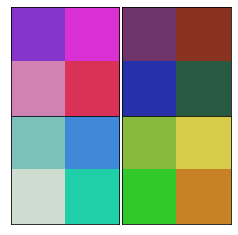

In [ ]:
fig = plt.figure(figsize=(4,4))
outer = gridspec.GridSpec(2, 2, wspace=0., hspace=0.)

for j in range(4):
    ax = plt.Subplot(fig, outer[j])

    ax.imshow(tab16_2x[j])

    ax.set_xticks([])
    ax.set_yticks([])
    fig.add_subplot(ax)

fig.show()

In [ ]:
lvl_0 = np.zeros((2,2),dtype=object)
lvl_1 = np.zeros((2,2),dtype=object)
lvl_2 = np.zeros((2,2),dtype=object)
tab_weights = []

idx1=-1
for i in gmap.neurons.keys():
    lvl_0[i] = gmap.neurons[i]
    gmap_1 = lvl_0[i].child_map
    idx1+=1

    idx2=-1
    for j in gmap_1.neurons.keys():
        lvl_1[j] = gmap_1.neurons[j]
        gmap_2 = lvl_1[j].child_map
        idx2+=1

        idx3=-1
        for k in gmap_2.neurons.keys():
            lvl_2[k] = gmap_2.neurons[k]
            
            if lvl_2[k].child_map is not None:
                gmap_3 = lvl_2[k].child_map
            else:
                gmap_3 = lvl_2[k]
            idx3+=1

            idx4=-1
            try:
                for l in np.concatenate(gmap_3.weights_map[0]):
                    idx4+=1
                    tab_weights.append([idx1,idx2,idx3,idx4,l])
            except:
                for l in np.concatenate(gmap_3._Neuron__weight_map[0]):
                    idx4+=1
                    tab_weights.append([idx1,idx2,idx3,idx4,l])

tab_weights = np.array(tab_weights)
print(tab_weights.shape)
tab_weights

(256, 5)


array([[0, 0, 0, 0, array([0.40001374, 0.20671726, 0.83069416])],
       [0, 0, 0, 1, array([0.33322367, 0.23432446, 0.94664094])],
       [0, 0, 0, 2, array([0.49372257, 0.1030418 , 0.94490221])],
       ...,
       [3, 3, 3, 1, array([0.91855109, 0.5320465 , 0.08864762])],
       [3, 3, 3, 2, array([0.83536531, 0.53989307, 0.30887601])],
       [3, 3, 3, 3, array([0.90488153, 0.46577634, 0.20653181])]],
      dtype=object)

In [ ]:
tab256_5 = np.array(tab_weights[:,-1].tolist())

tab256_2x = tab256_5.reshape(4,4,4,2,2,3)

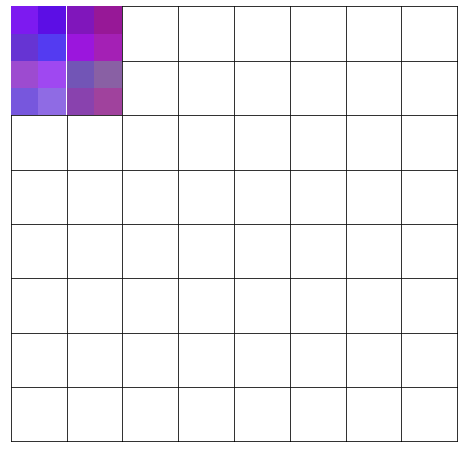

In [ ]:
fig = plt.figure(figsize=(8,8))
outer = gridspec.GridSpec(2, 2, wspace=.0, hspace=.0)

for i in range(4):
    inner = gridspec.GridSpecFromSubplotSpec(2, 2,
                    subplot_spec=outer[i], wspace=.0, hspace=.0)

    for j in range(4):
        if i==0 and j==0:
            ax = plt.Subplot(fig, inner[j])
            inner2 = gridspec.GridSpecFromSubplotSpec(2, 2,
                        subplot_spec=inner[j], wspace=.0, hspace=.0)


            for k in range(4):
                ax1 = plt.Subplot(fig, inner2[k])

                ax1.imshow(tab256_2x[i,j,k],origin="lower")
                ax1.axis('off')

                ax1.set_xticks([]) ; ax1.set_yticks([])
                fig.add_subplot(ax1)
        else:
            ax = plt.Subplot(fig, inner[j])
            inner2 = gridspec.GridSpecFromSubplotSpec(2, 2,
                        subplot_spec=inner[j], wspace=.0, hspace=.0)

            for k in range(4):
                ax1 = plt.Subplot(fig, inner2[k])
                #ax1.imshow(tab256_2x[i,j,k],origin="lower")
                #ax1.axis('off')
                ax1.set_xticks([]) ; ax1.set_yticks([])
                fig.add_subplot(ax1)
plt.show()

In [ ]:
tab256_2xT = np.transpose(tab256_2x, (0,2,1,3,4,5)).reshape(4,4,4,2,2,3)

In [ ]:
np.transpose(tab256_2x, (0,1,2,4,3,5)).reshape(4,4,4,2,2,3)[0,0]

array([[[[0.40001374, 0.20671726, 0.83069416],
         [0.49372257, 0.1030418 , 0.94490221]],

        [[0.33322367, 0.23432446, 0.94664094],
         [0.36392465, 0.05597361, 0.90159525]]],


       [[[0.60806049, 0.08972033, 0.87000943],
         [0.50261614, 0.08818855, 0.73441612]],

        [[0.64683327, 0.12827871, 0.71313403],
         [0.59536579, 0.09463338, 0.59529699]]],


       [[[0.46806224, 0.34438305, 0.86768883],
         [0.6177905 , 0.29573308, 0.81905665]],

        [[0.56305641, 0.42279438, 0.8974439 ],
         [0.62480017, 0.2835048 , 0.94749121]]],


       [[[0.53853565, 0.25962637, 0.68609191],
         [0.44822803, 0.3360841 , 0.7143971 ]],

        [[0.62855281, 0.25944312, 0.61711839],
         [0.54078101, 0.37717423, 0.64412695]]]])

In [ ]:
tab256_2x[0,0]

array([[[[0.40001374, 0.20671726, 0.83069416],
         [0.33322367, 0.23432446, 0.94664094]],

        [[0.49372257, 0.1030418 , 0.94490221],
         [0.36392465, 0.05597361, 0.90159525]]],


       [[[0.60806049, 0.08972033, 0.87000943],
         [0.64683327, 0.12827871, 0.71313403]],

        [[0.50261614, 0.08818855, 0.73441612],
         [0.59536579, 0.09463338, 0.59529699]]],


       [[[0.46806224, 0.34438305, 0.86768883],
         [0.56305641, 0.42279438, 0.8974439 ]],

        [[0.6177905 , 0.29573308, 0.81905665],
         [0.62480017, 0.2835048 , 0.94749121]]],


       [[[0.53853565, 0.25962637, 0.68609191],
         [0.62855281, 0.25944312, 0.61711839]],

        [[0.44822803, 0.3360841 , 0.7143971 ],
         [0.54078101, 0.37717423, 0.64412695]]]])

In [ ]:
tab256_2x.shape

(4, 4, 4, 2, 2, 3)

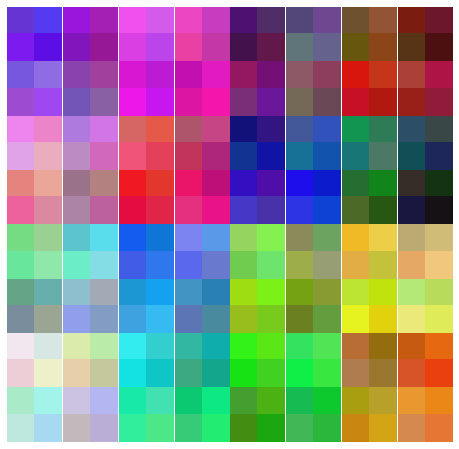

In [ ]:
fig = plt.figure(figsize=(8,8))
outer = gridspec.GridSpec(2, 2, wspace=.0, hspace=.0)

for i in range(4):
    inner = gridspec.GridSpecFromSubplotSpec(2, 2,
                    subplot_spec=outer[i], wspace=.0, hspace=.0)

    for j in range(4):
        ax = plt.Subplot(fig, inner[j])
        inner2 = gridspec.GridSpecFromSubplotSpec(2, 2,
                    subplot_spec=inner[j], wspace=.0, hspace=.0)

        for k in range(4):
            ax1 = plt.Subplot(fig, inner2[k])

            ax1.imshow(tab256_2x[i,j,k])
            ax1.axis('off')

            ax1.set_xticks([]) ; ax1.set_yticks([])
            fig.add_subplot(ax1)
plt.show()

<a name="S3_7"></a>
## Test hyperparams auto

In [ ]:
from hyperopt import (fmin, 
                      tpe, 
                      hp, 
                      Trials, 
                      STATUS_OK)

In [ ]:
# finding the 2 parameters at the same time

rows = data_color.shape[0]
som_x = int(np.sqrt(5*np.sqrt(rows)))
som_y = som_x

space = {'sig' : hp.uniform('sig', som_x/10, som_x/2.01),
         'learnR' :hp.uniform('learnR', 0.001, 4)}

def som_fn(space):
    sig = space['sig']
    learnR = space['learnR']

    val = MiniSom(som_x, som_y,
                  data_color.shape[1],
                  sig,
                  learnR,
                  ).quantization_error(data_color)

    return {'loss': val, 'status': STATUS_OK}


trials = Trials()
best_params = fmin(
    fn = som_fn,
    space = space,
    algo = tpe.suggest,
    max_evals = 10,
    trials = trials
    )

sigma = best_params['sig']
learning_rate = best_params['learnR']

print("sigma = %f ; learning rate %f \n" % (sigma, learning_rate))

100%|██████████| 10/10 [00:02<00:00,  3.78it/s, best loss: 0.23785618417138957]
sigma = 5.132646 ; learning rate 1.062127 



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


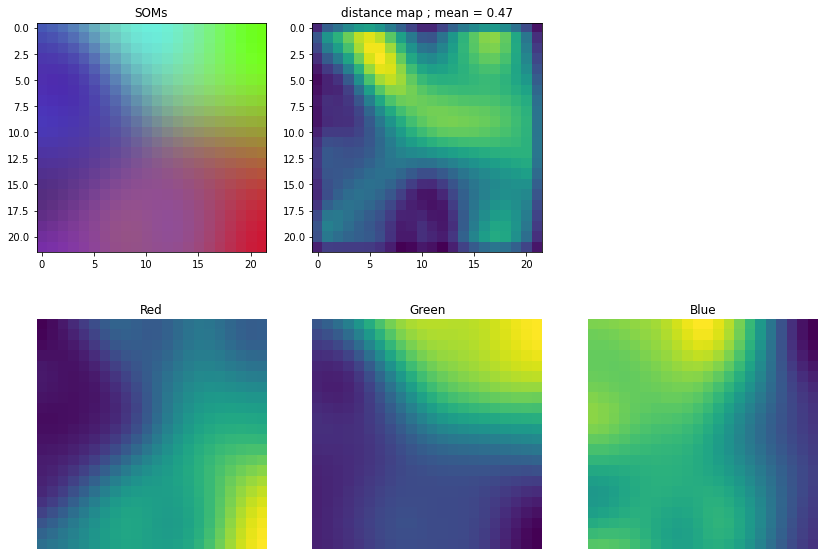

In [ ]:
print("sigma = %.2f ; learning rate %.2f \n" % (sigma, learning_rate))

som, wts_color = train_som(data_color, sigma, learning_rate, 1000, verbose=False)
som_color(data_color, som, wts_color, color_names) # sigma = 9.263, learning_rate = 3.905

In [ ]:
# finding sigma only
rows = data_color.shape[0]
som_x = int(np.sqrt(5*np.sqrt(rows)))
som_y = som_x

learning_rate = 1

best_sig = fmin(
    fn = lambda sig : MiniSom(som_x,som_y,
                              data_color.shape[1],
                              sig,
                              learning_rate
                              ).quantization_error(data_color),
    space = hp.uniform("sig", som_x/10, som_x/2.01),
    algo = tpe.suggest,
    max_evals=200)

sigma = best_sig["sig"]
print(sigma)

100%|██████████| 200/200 [00:48<00:00,  4.12it/s, best loss: 0.23659006291835552]
8.762504662317241


sigma = 8.76 ; learning rate 1.00 



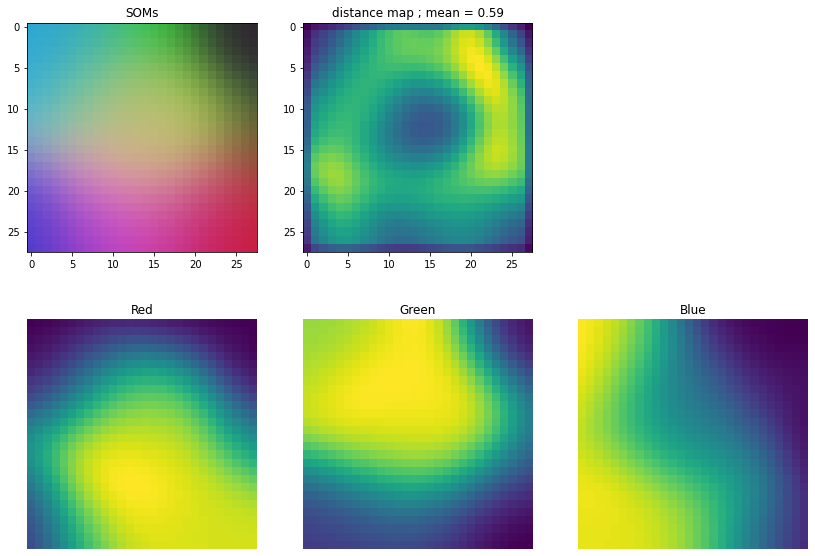

In [ ]:
print("sigma = %.2f ; learning rate %.2f \n" % (sigma, learning_rate))

som, wts_color = train_som(data_color, sigma, learning_rate, 1000, verbose=False)
som_color(data_color, som, wts_color, color_names)

<a name="S4"></a>
# Galaxy catalogs

<a name="S4_1"></a>
## Loading Datasets

In [23]:
from astropy.io import fits

In [24]:
# COSMOS
path_CS_fits = "real_galaxy_catalog_25.2_fits.fits"

with fits.open(path_CS_fits) as hdul_cs:
    hdr = hdul_cs[0].header # header
    data_cs = hdul_cs[1].data # data
    cols = hdul_cs[1].columns # cols
    Names_cs = cols.names # cols names

In [25]:
# True Universe
path_TU = "TU_created.fits"

with fits.open(path_TU) as hdul_tu:
    hdr = hdul_tu[0].header # header
    data_tu = hdul_tu[1].data # data_tu
    cols = hdul_tu[1].columns # cols
    Names_tu = cols.names # cols names

In [ ]:
hdul_cs.info()
Names_cs

Filename: real_galaxy_catalog_25.2_fits.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     36   87798R x 14C   [J, D, D, D, 8D, 16D, 5J, D, D, D, J, J, 3D, 4D]   


['IDENT',
 'mag_auto',
 'flux_radius',
 'zphot',
 'sersicfit',
 'bulgefit',
 'fit_status',
 'fit_mad_s',
 'fit_mad_b',
 'fit_dvc_btt',
 'use_bulgefit',
 'viable_sersic',
 'hlr',
 'flux']

In [ ]:
hdul_tu.info()
Names_tu

Filename: TU_created.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     20   314709R x 6C   [D, D, D, D, D, D]   


['mag', 'half_light_radius', 'q', 'SSersic_n', 'PA', 'bt']

<a name="S4_2"></a>
## Definition : cuts and normalizations

In [26]:
def sigmoid(tab):
    return 1/(1+np.exp(-2*tab))

def cut_normalize_view(catalog, norm=True):
    """catalog : choose between -TU- and -COSMOS-"""
    if catalog=="TU":
        cat_tu = data_tu.copy()
        Datas = {"mag" : cat_tu['mag'],
                 "hlr" : cat_tu['half_light_radius'],
                 "sersic" : cat_tu['SSersic_n'],
                 "q" : cat_tu['q']}
    elif catalog=="COSMOS":
        cat_cs = data_cs.copy()
        Datas = {"mag" : cat_cs['mag_auto'],
                 "hlr" : cat_cs['sersicfit'][:,1],
                 "sersic" : cat_cs['sersicfit'][:,2],
                 "q" : cat_cs['sersicfit'][:,3]}
    else:
        raise ValueError("choose between -TU- and -COSMOS- ; not " + str(catalog))


    # initial view
    plt.figure(figsize=(16,4))
    for i, vars in enumerate(Datas):
        plt.subplot(1,4,i+1)
        plt.title(vars +' ; min=%.2f, max=%.2f' % (min(Datas[vars]), max(Datas[vars])))
        plt.hist(Datas[vars], bins=100)
    plt.tight_layout()
    plt.show()


    if norm: # modifications in the catalog

        # normalize
        Datas['mag'] /= 33 
        Datas['sersic'] /= max(Datas['sersic'])
        #Datas["sersic"] = sigmoid(Datas["sersic"])

        # convert hlr
        if catalog=="COSMOS":
            Datas["hlr"] *= 0.03

        # delete hlr problems
        idx = np.where(Datas['hlr']>2)[0]
        print("hlr : nb d'elements suppr", idx.shape[0])
        for i in Datas:
            Datas[i] = np.delete(Datas[i], idx)

        # delete sersic problems
        if catalog=="COSMOS":
            idx_sup = np.where(Datas['sersic']>1-.001)[0]
            idx_inf = np.where(Datas['sersic']<min(Datas['sersic'])+.001)[0]
            print("sersic : nb d'elements suppr", idx_sup.shape[0]+idx_inf.shape[0])
            for i in Datas:
                Datas[i] = np.delete(Datas[i],np.hstack([idx_sup,idx_inf]))

        # final view
        plt.figure(figsize=(16,4))
        for i, vars in enumerate(Datas):
            plt.subplot(1,4,i+1)
            plt.title(vars +' ; min=%.2f, max=%.2f' % (min(Datas[vars]), max(Datas[vars])))
            plt.hist(Datas[vars], bins=100)
        plt.tight_layout()
        plt.show()
        
    return Datas

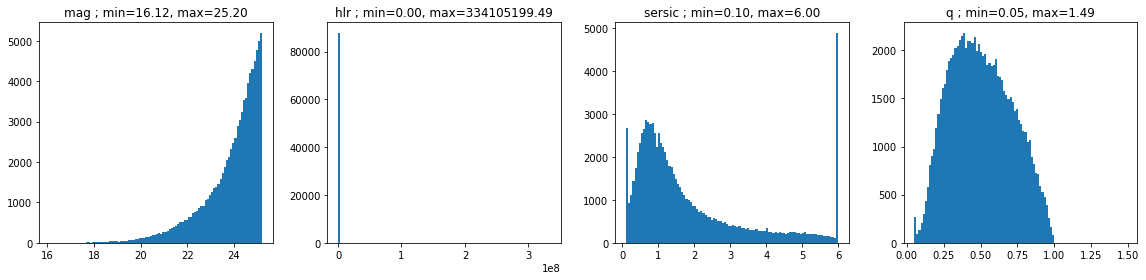

hlr : nb d'elements suppr 2015
sersic : nb d'elements suppr 6217


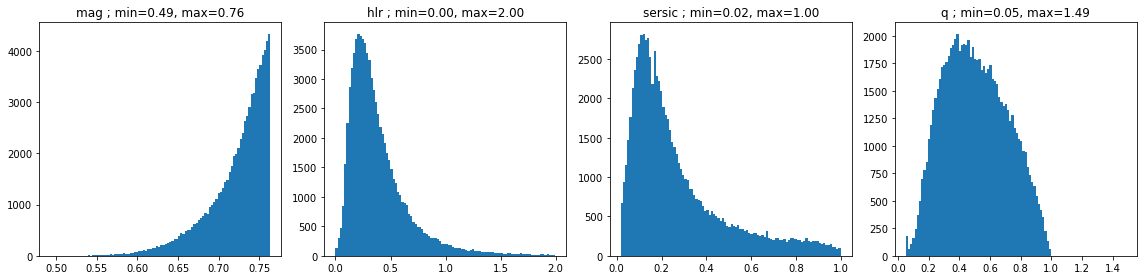

In [27]:
data_cs_norm = cut_normalize_view("COSMOS")

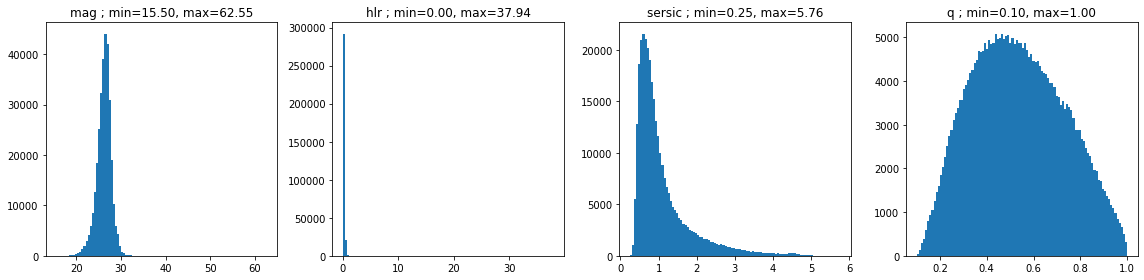

hlr : nb d'elements suppr 31


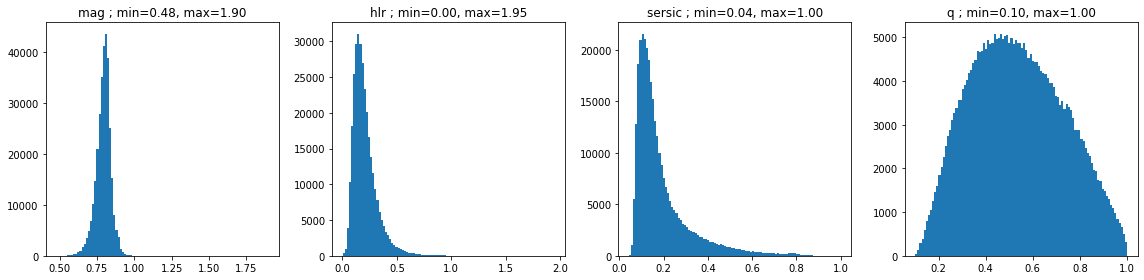

In [28]:
data_tu_norm = cut_normalize_view("TU")

### COSMOS ; Cuts and normalizations

#### Magnitude

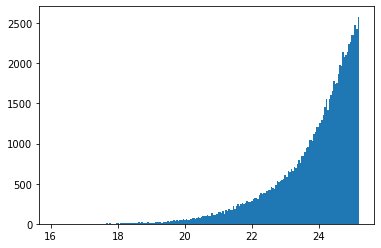

In [ ]:
plt.hist(data_cs['mag_auto'], bins=200);

In [ ]:
print(max(data_cs['mag_auto']) , min(data_cs['mag_auto']))

25.199989318847656 16.11771583557129


In [ ]:
# normalize
data_cs['mag_auto'] /= 33

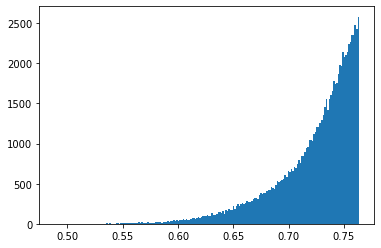

In [ ]:
plt.hist(data_cs['mag_auto'], bins=200);

#### Half light radius cut and conversion :

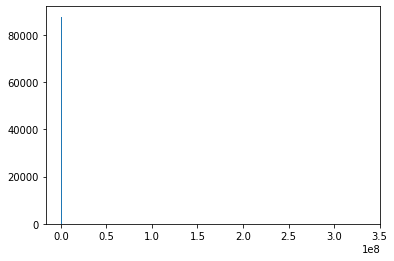

In [ ]:
plt.hist(data_cs['sersicfit'][:,1], bins=200);

In [ ]:
# converting hlr
data_cs['sersicfit'][:,1] *= 0.03

In [ ]:
def cut_hight_hlr(cat, lim): # delete hlr problems
    idx = np.where(cat['sersicfit'][:,1]>lim)[0]
    print("nb d'elements suppr", idx.shape)
    cat = np.delete(cat,idx)
    return cat

data_cs = cut_hight_hlr(data_cs, 2) # cut hight hlr values on the full catalog

nb d'elements suppr (2015,)


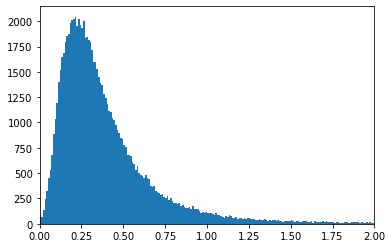

In [ ]:
plt.hist(data_cs['sersicfit'][:,1], bins=200)
plt.xlim(0,2);

#### Sersic normalization... and cuts

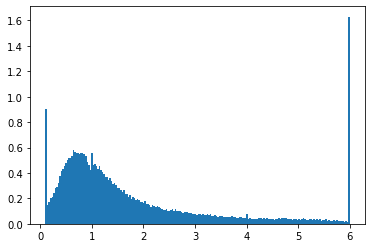

In [ ]:
plt.hist(data_cs['sersicfit'][:,2], bins=200, density=True);

In [ ]:
np.where(data_cs['sersicfit'][:,2]<0.11)[0].shape

(2063,)

In [ ]:
np.where(data_cs['sersicfit'][:,2]>5.99)[0].shape

(4032,)

In [ ]:
data_cs['sersicfit'][:,2] /= max(data_cs['sersicfit'][:,2]) # normalization

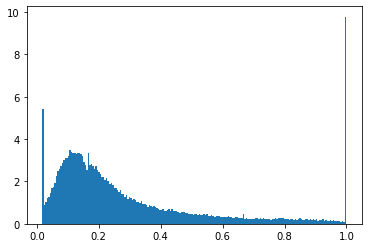

In [ ]:
plt.hist(data_cs['sersicfit'][:,2], bins=200, density=True);

In [ ]:
data_cs = data_cs[ np.where( data_cs['sersicfit'][:,2] < 1 )[0] ]

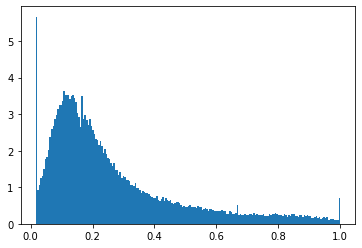

In [ ]:
plt.hist(data_cs['sersicfit'][:,2], bins=200, density=True);

In [ ]:
data_cs = data_cs[ np.where( data_cs['sersicfit'][:,2] > min(data_cs['sersicfit'][:,2]) )[0] ]

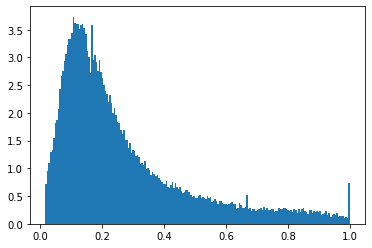

In [ ]:
plt.hist(data_cs['sersicfit'][:,2], bins=200, density=True);

#### q cut :

In [ ]:
np.where( data_cs['sersicfit'][:,3] > 1 )[0].shape

(14,)

In [ ]:
data_cs = data_cs[ np.where( data_cs['sersicfit'][:,3] < 1 )[0] ]

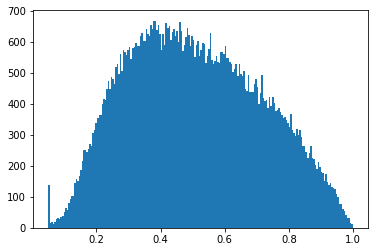

In [ ]:
plt.hist(data_cs['sersicfit'][:,3], bins=200);

In [ ]:
np.where( data_cs['sersicfit'][:,3] < 0.06 )[0].shape

(157,)

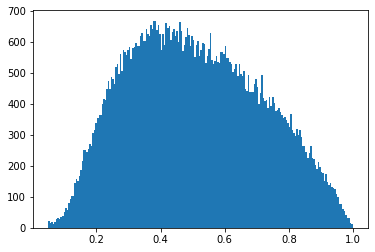

In [ ]:
data_cs = data_cs[ np.where( data_cs['sersicfit'][:,3] > 0.05 )[0] ]
plt.hist(data_cs['sersicfit'][:,3], bins=200);

#### Intensity at the hlr :

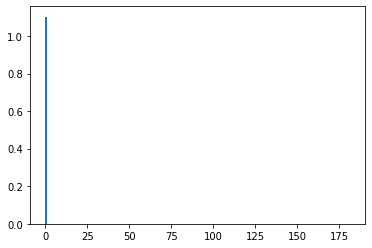

In [ ]:
plt.hist(data_cs['sersicfit'][:,0], bins=200, density=True);

In [ ]:
print(max(data_cs['sersicfit'][:,0]))
print(np.mean(data_cs['sersicfit'][:,0]))
print(min(data_cs['sersicfit'][:,0]))

181.12170846645134
0.07419850816778073
0.0


In [ ]:
np.where( data_cs['sersicfit'][:,0] > 0.3 )[0].shape

(331,)

In [ ]:
data_cs = data_cs[ np.where( data_cs['sersicfit'][:,0] < 0.3 )[0] ]

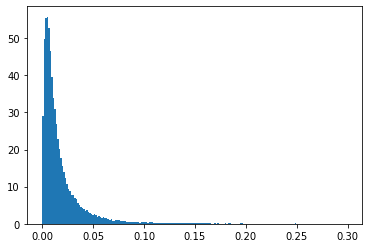

In [ ]:
plt.hist(data_cs['sersicfit'][:,0], bins=200, density=True);

In [ ]:
print(max(data_cs['sersicfit'][:,0]))
print(np.mean(data_cs['sersicfit'][:,0]))
print(min(data_cs['sersicfit'][:,0]))

0.29857793358805385
0.018726944985234334
0.0


<a name="S4_3"></a>
## Selecting variables

In [29]:
variables_cs = [*data_cs_norm.keys()]

caption = Label(value='Select some variables (at least 2)')
boxs_cs = [Checkbox(description=i) for i in variables_cs]

display(caption, *boxs_cs)

Label(value='Select some variables (at least 2)')

Checkbox(value=False, description='mag')

Checkbox(value=False, description='hlr')

Checkbox(value=False, description='sersic')

Checkbox(value=False, description='q')

In [30]:
dataset_i = []
vars_cs = []
cols = 0
for i, var in enumerate(variables_cs):
    if boxs_cs[i].value==1:
        dataset_i.append(data_cs_norm[var])
        vars_cs.append(var)
        cols += 1

assert cols>1, "pick at least 2 variables"

choice_cs = np.vstack([*dataset_i]).T


nb_cs = data_cs.shape[0] # rows number 
print("Nombre d'éléments :", nb_cs)
print("Selected variables :",vars_cs)

Nombre d'éléments : 87798
Selected variables : ['mag', 'hlr']


In [31]:
variables_tu = [*data_tu_norm.keys()]

caption = Label(value='Select some variables (at least 2)')
boxs_tu = [Checkbox(description=i) for i in variables_tu]

display(caption, *boxs_tu)

Label(value='Select some variables (at least 2)')

Checkbox(value=False, description='mag')

Checkbox(value=False, description='hlr')

Checkbox(value=False, description='sersic')

Checkbox(value=False, description='q')

In [32]:
dataset_i = []
vars_tu = []
cols = 0
for i, var in enumerate(variables_tu):
    if boxs_tu[i].value==1:
        dataset_i.append(data_tu_norm[var])
        vars_tu.append(var)
        cols += 1

assert cols>1, "pick at least 2 variables"

choice_tu = np.vstack([*dataset_i]).T

nb_tu = data_tu.shape[0] # rows number 
print("Nombre d'éléments :", nb_tu)
print("Selected variables :",vars_tu)

Nombre d'éléments : 314709
Selected variables : ['mag', 'hlr']


In [35]:
xtrain_cs, xtest_cs = train_test_split(choice_cs, test_size=0.1)

In [36]:
xtrain_tu, xtest_tu = train_test_split(choice_tu, test_size=0.1)

<a name="S4_4"></a>
## COSMOS ; SOMs training and visualisation

In [ ]:
sigma = 9
learning_rate = 1

som_cs, weights_cs = train_som(xtrain_cs, sigma, learning_rate, 1000, size=(20,20))
PlotSOMs(xtrain_cs, som_cs, weights_cs, vars_cs)

In [ ]:
Heatmap(som_tu, xtrain_cs)

### Gx mag cut

datasets normalized, training on TU, Heatmap on COSMOS first

visualiazation of heatmaps for TU mag sup/inf max(mag(TU))

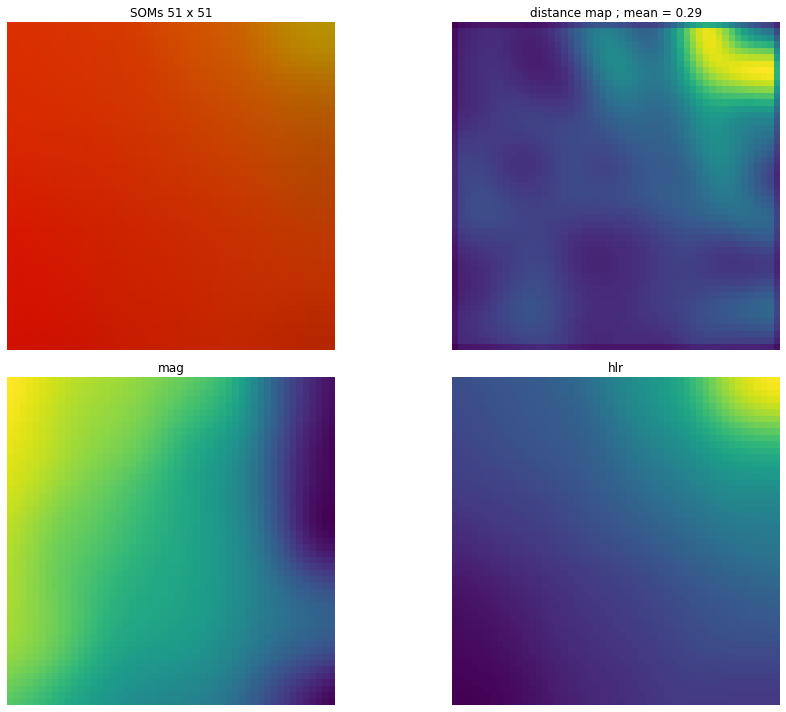

In [ ]:
sigma = 10
learning_rate = 1

som_tu, weights_tu = train_som(xtrain_tu, sigma, learning_rate, 1000)
PlotSOMs(xtrain_tu, som_tu, weights_tu, vars_tu)

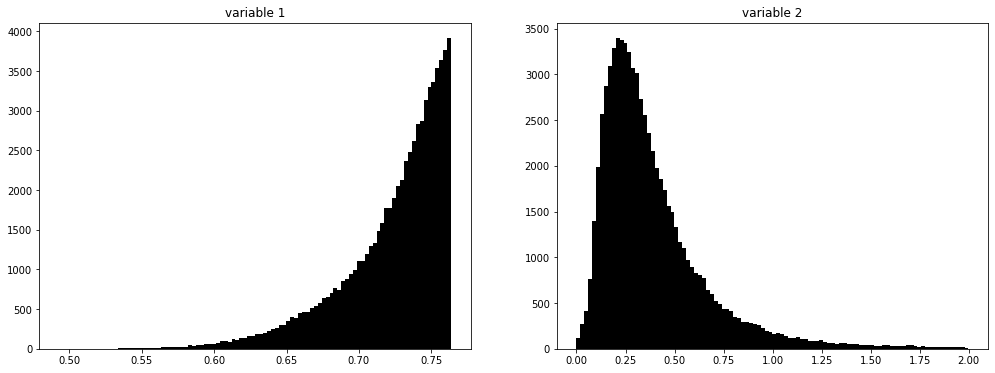

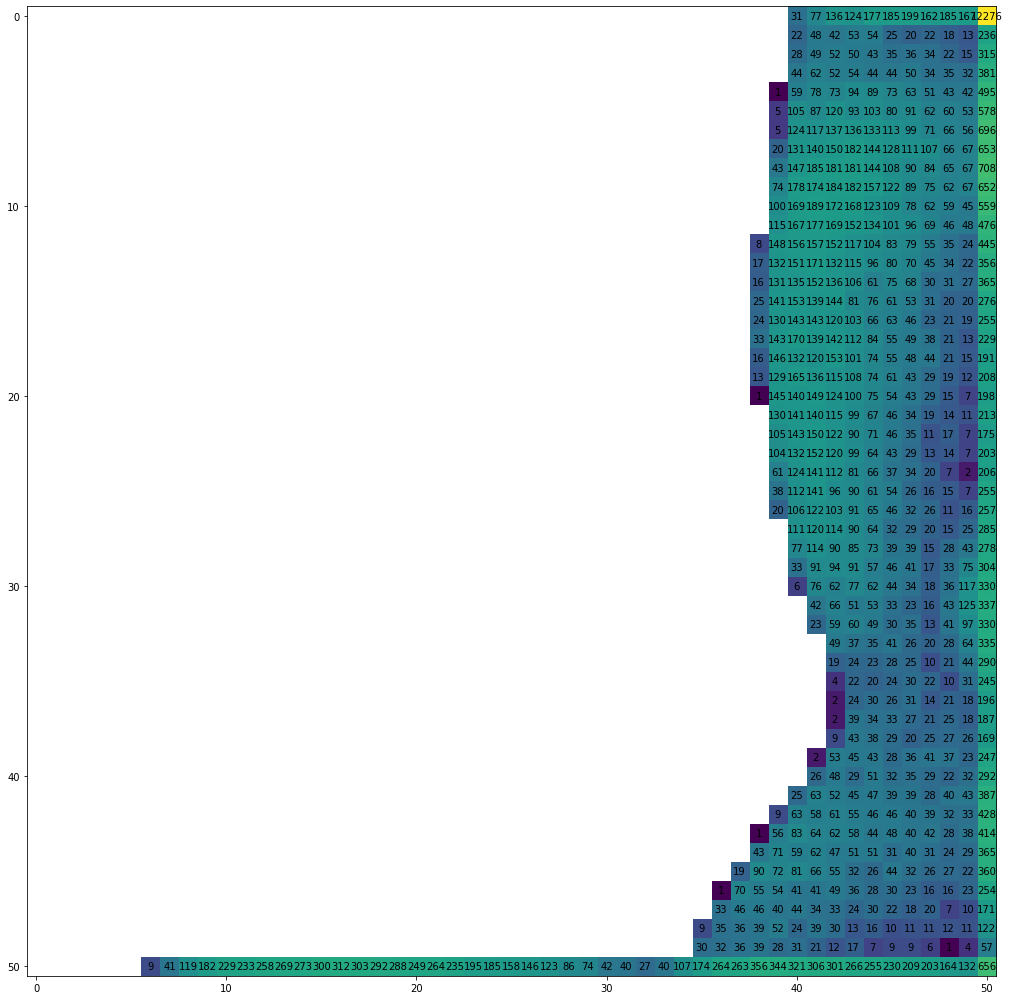

In [ ]:
Heatmap(som_tu, xtrain_cs)

In [ ]:
mag_tu_sup_cs = data_tu_norm['mag'][np.where(data_tu_norm['mag']>0.7636)[0]]
hlr_mag_tu_sup_cs = data_tu_norm['hlr'][np.where(data_tu_norm['mag']>0.7636)[0]]

cut_mag_sup = np.vstack([mag_tu_sup_cs, hlr_mag_tu_sup_cs]).T

In [ ]:
mag_tu_inf_cs = data_tu_norm['mag'][np.where(data_tu_norm['mag']<0.7636)[0]]
hlr_mag_tu_inf_cs = data_tu_norm['hlr'][np.where(data_tu_norm['mag']<0.7636)[0]]

cut_mag_inf = np.vstack([mag_tu_inf_cs, hlr_mag_tu_inf_cs]).T

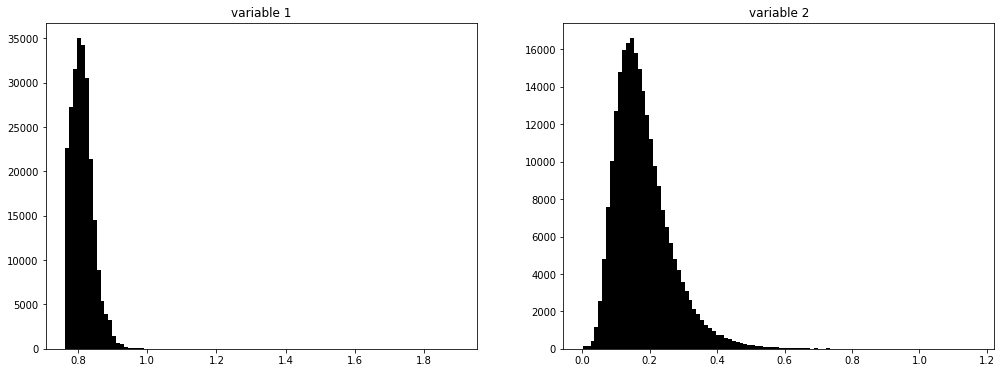

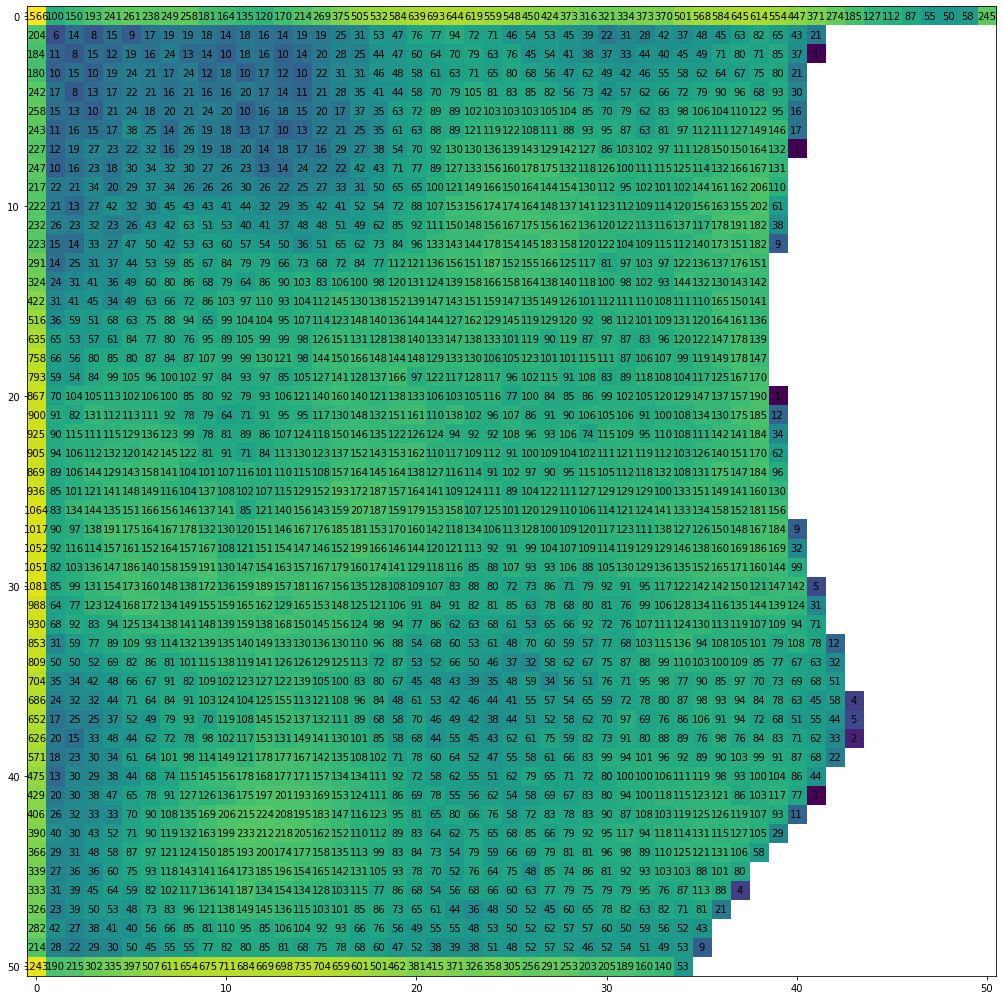

In [ ]:
Heatmap(som_tu, cut_mag_sup)

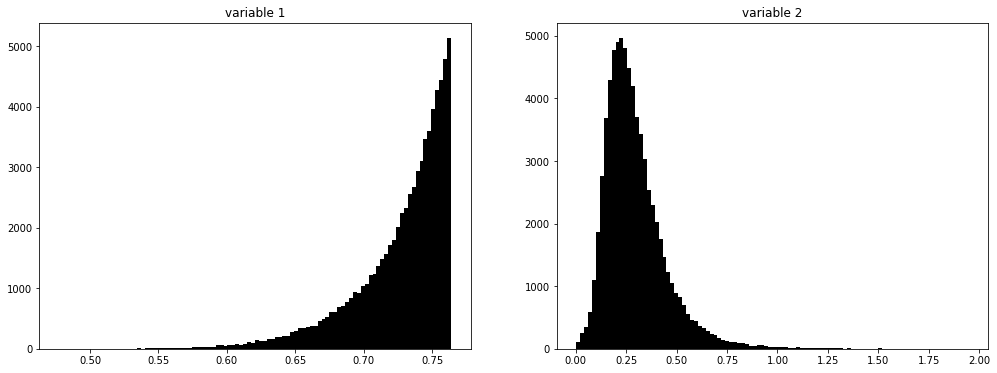

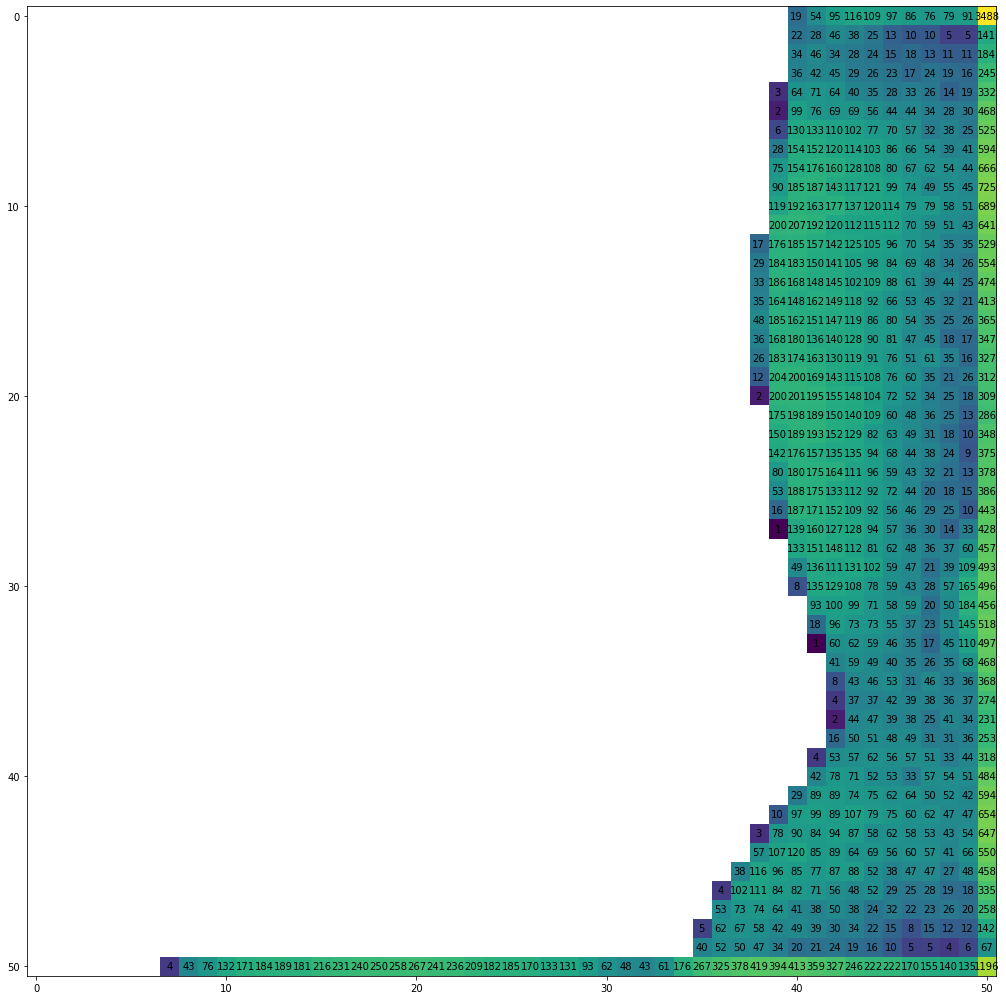

In [ ]:
Heatmap(som_tu, cut_mag_inf)

### Heatmap som_tu, xtrain_cs

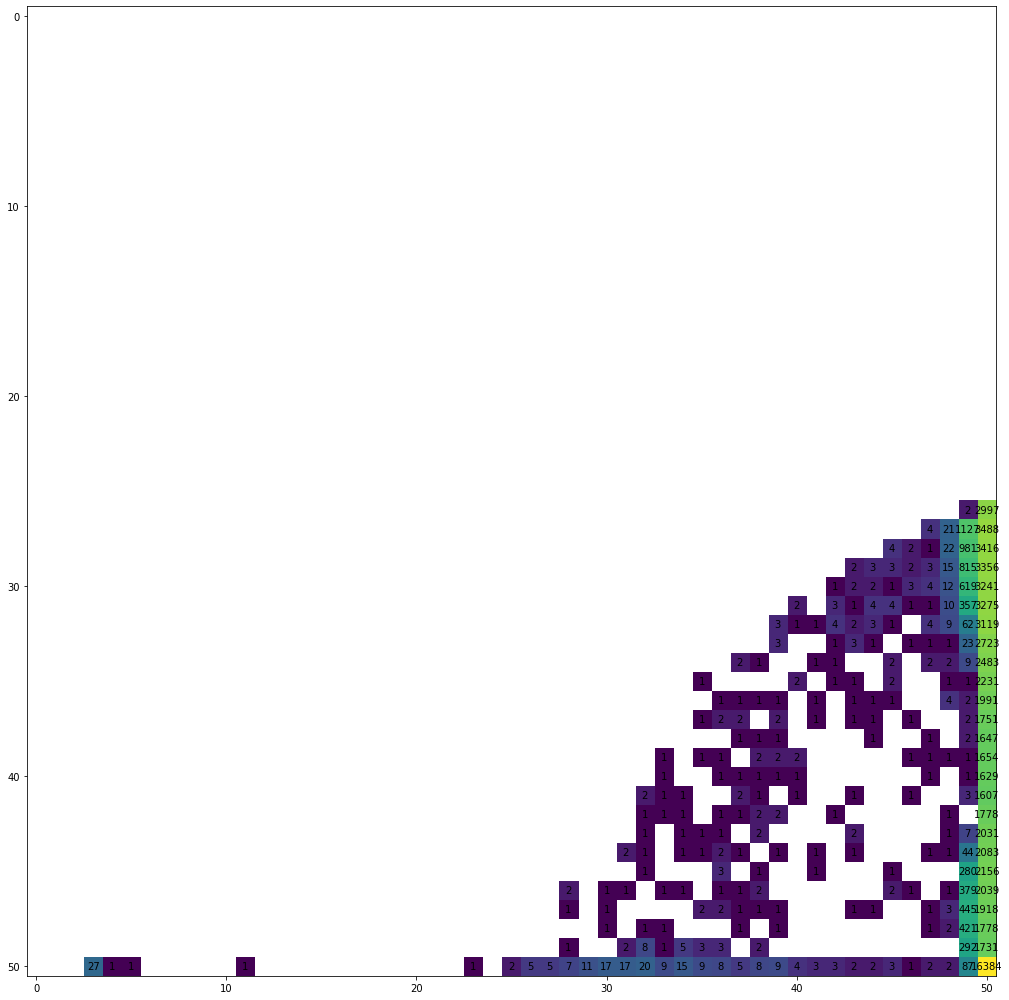

In [ ]:
# heatmap train TU , proj hit COSMOS (non normalized)
Heatmap(som_tu, xtrain_cs)

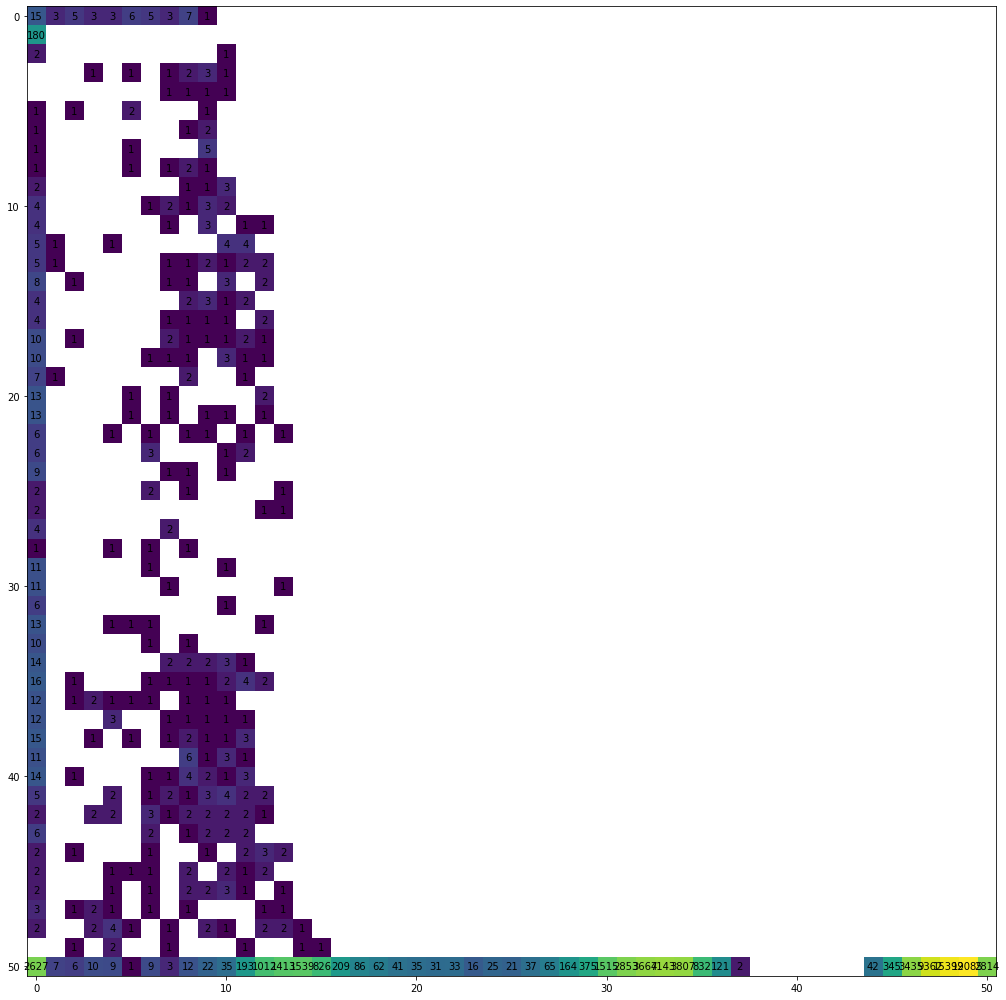

In [ ]:
# heatmap train TU , proj hit COSMOS (normalized)
Heatmap(som_tu, xtrain_cs)

### Interactive plot

In [ ]:
interactive_plot(choice_cs, names=vars_cs)

interactive(children=(FloatSlider(value=9.0, description='sigma', max=18.0, min=1.0, step=0.5), FloatSlider(va…

## TU ; SOMs training and visualisation

In [ ]:
sigma = 10
learning_rate = 1

som_tu, weights_tu = train_som(xtrain_tu, sigma, learning_rate, 1000)
PlotSOMs(xtrain_tu, som_tu, weights_tu, vars_tu)

### Dataset non normalisé

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


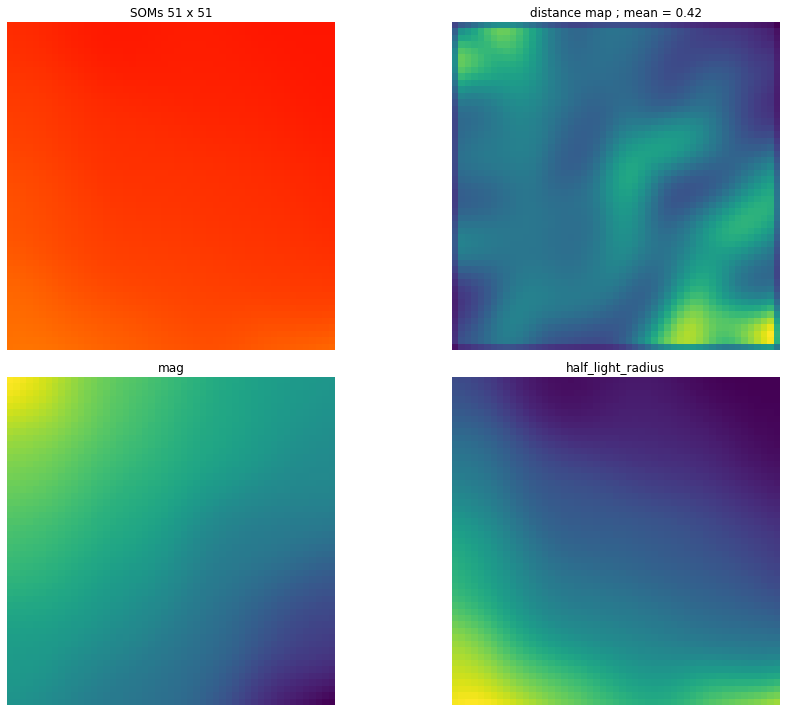

In [ ]:
sigma = 10
learning_rate = 1

som_tu, weights_tu = train_som(xtrain_tu, sigma, learning_rate, 1000)
PlotSOMs(xtrain_tu, som_tu, weights_tu, vars_tu)

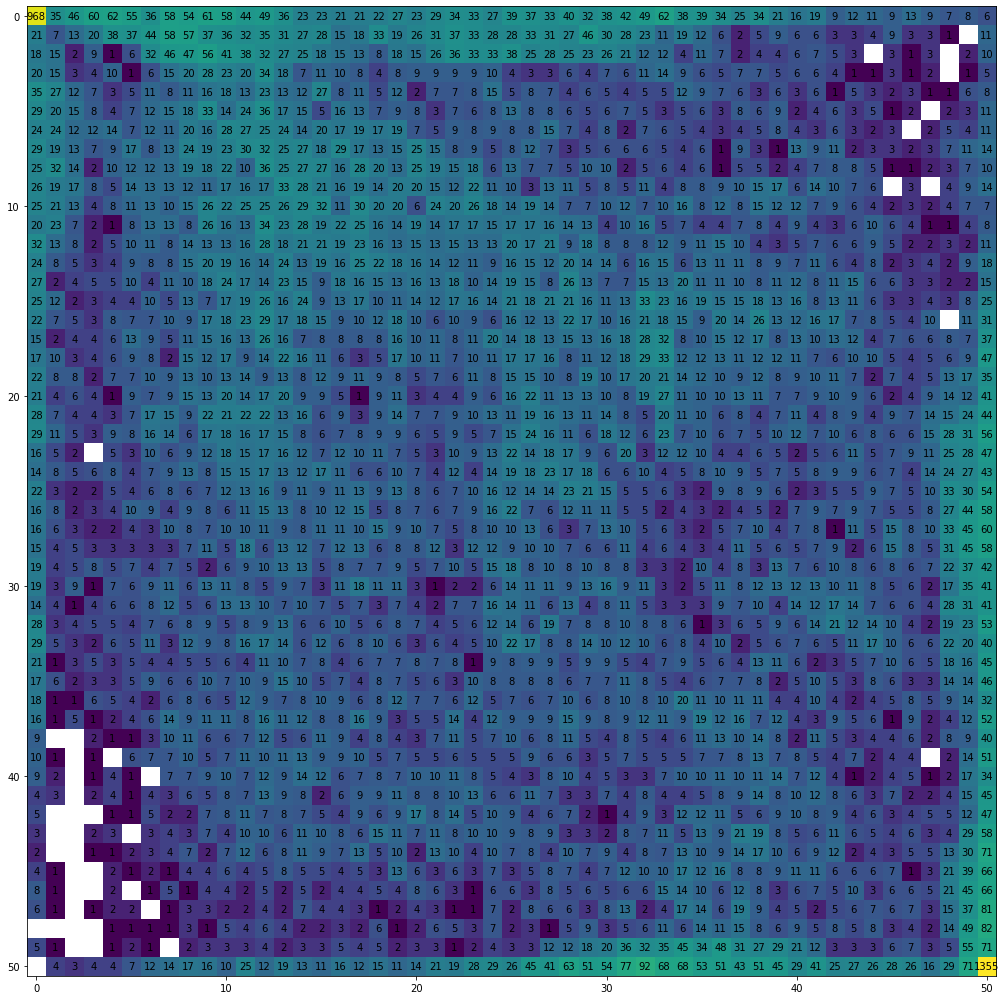

In [ ]:
# heatmap train test meme catalogue
Heatmap(som_tu, xtest_tu)

### Dataset normalisé

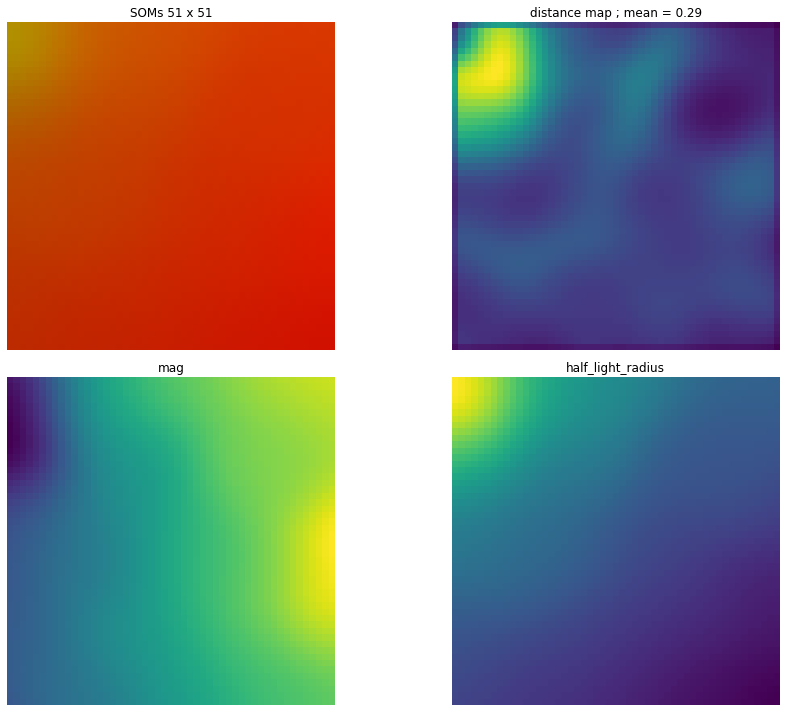

In [ ]:
sigma = 10
learning_rate = 1

som_tu, weights_tu = train_som(xtrain_tu, sigma, learning_rate, 1000)
PlotSOMs(xtrain_tu, som_tu, weights_tu, vars_tu)

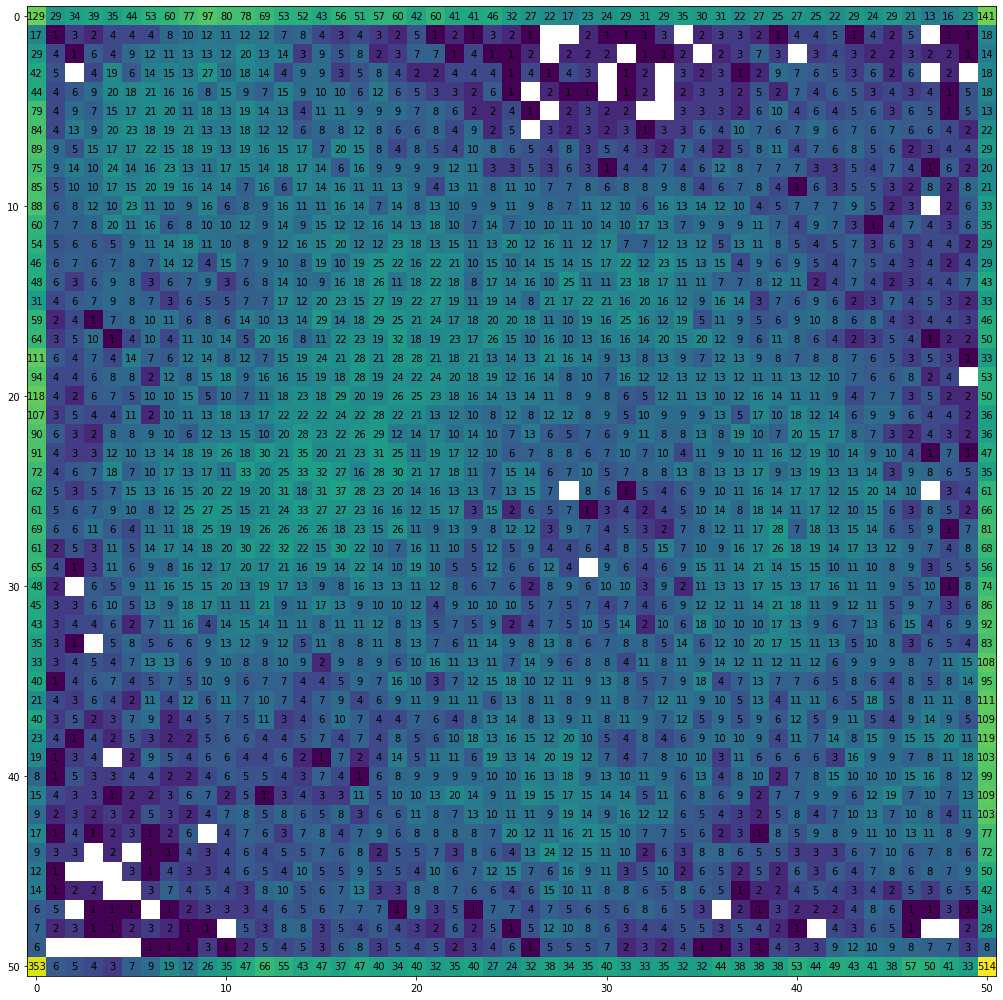

In [ ]:
# heatmap train test meme catalogue
Heatmap(som_tu, xtest_tu)

### Tests

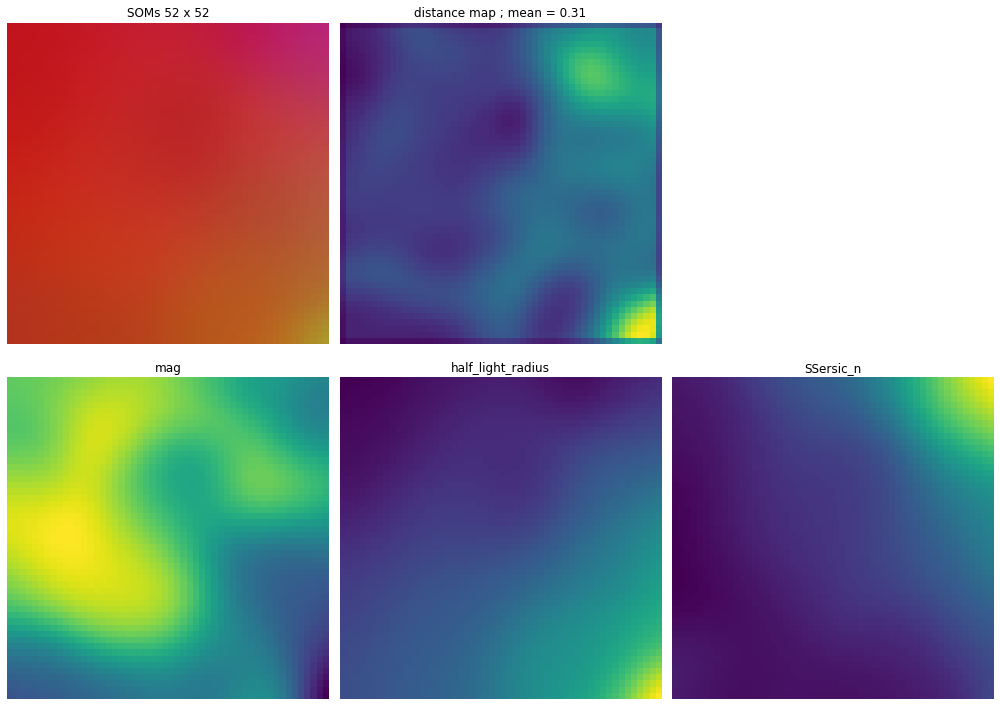

In [ ]:
sigma = 10
learning_rate = 1

som, weights = train_som(choice_tu, sigma, learning_rate, 5000)
PlotSOMs(choice_tu, som, weights, vars_tu)

In [ ]:
interactive_plot(choice_tu, names=vars_tu)